In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import xgboost as xgb
import scipy.stats as st
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, TimeSeriesSplit
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from xgboost import plot_importance
from sklearn.model_selection import ParameterSampler
# import jtplot submodule from jupyterthemes
#from jupyterthemes import jtplot
#jtplot.style()

In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true)))*100

In [15]:
%%html
<img src ='img/my_image.jpg', width = 200, height = 200>

# Data pre-processing

## Reading the data (MATLAB files)

In [21]:
#data_mat = scipy.io.loadmat('Boosting_data_9.mat') #Oil production data
#data_mat_test = scipy.io.loadmat('Boosting_data_9_test.mat') #Oil well test data
data_mat = scipy.io.loadmat('Boosting_data_10.mat') #Oil production data
data_mat_test = scipy.io.loadmat('Boosting_data_10_test.mat') #Oil well test data

## True production profile

In [22]:
names = ['oil_rate_meter', 'gas_rate', 'gas_rate_meter', 'choke_opening', 'P_WF', 'T_WF', 'P_WHCU', 'T_WHCU', 'P_WHCD', 
         'T_WHCD', 'P_riser', 'T_riser'] #Names of the variables contained in the data
data = pd.DataFrame(data_mat['oil_rate_bbl']) #Start forming the dataset from the .mat file
#Append the data into data frame from the MATLAB file
for name in names:
    data = pd.concat([data, pd.DataFrame(data_mat[name])], axis = 1, ignore_index = True)
data = pd.DataFrame(data.values, columns = ['oil_rate_bbl', 'oil_rate_meter', 'gas_rate', 'gas_rate_meter', 'choke_opening', 
                                            'P_WF', 'T_WF', 'P_WHCU', 'T_WHCU', 'P_WHCD', 'T_WHCD', 'P_riser', 'T_riser'])

#Form the features dataset. Drop the target variables and P, T riser (possible to include later to see if it helpts)
X = data.drop(columns = ['oil_rate_bbl', 'oil_rate_meter', 'gas_rate', 'gas_rate_meter', 'P_riser', 'T_riser'], inplace = False)

#Data for multiphase flow meter - flowrate measured by the multiphase flow meter
y_meter = pd.DataFrame(data[['oil_rate_meter']])
y_meter.columns = ['oil_rate_bbl']

#Data for true production 
y_true = pd.DataFrame(data['oil_rate_bbl'])

## Splitting the data on quarters (6 months periods) which are used for predictions

In [23]:
#Indicies for splitting
total_index = X.shape[0]
index_1 = round(total_index * 0.25)
index_2 = round(total_index * 0.5)
index_3 = round(total_index * 0.75)

#Quarter 1
X_1, y_1, y_1_true, y_1_meter = X.iloc[:index_1, :], y_meter.iloc[:index_1], y_true.iloc[:index_1], y_meter.iloc[:index_1]
#Quarter 2
X_2, y_2, y_2_true, y_2_meter = X.iloc[index_1 : index_2, :], y_meter.iloc[index_1 : index_2], y_true.iloc[index_1 : index_2], y_meter.iloc[index_1 : index_2]
#Quarter 3
X_3, y_3, y_3_true, y_3_meter = X.iloc[index_2 : index_3, :], y_meter.iloc[index_2 : index_3], y_true.iloc[index_2 : index_3], y_meter.iloc[index_2 : index_3]
#Quarter 4
X_4, y_4, y_4_true, y_4_meter = X.iloc[index_3 : , :], y_meter.iloc[index_3 :], y_true.iloc[index_3 :], y_meter.iloc[index_3 :]

## Well test profiles

In [24]:
names = ['gas_rate_test', 'P_WF_test', 'T_WF_test', 'P_WHCU_test', 'T_WHCU_test', 'P_WHCD_test', 'T_WHCD_test', 
         'P_riser_test', 'T_riser_test'] #Names of the variables contained in the data from well tests
data_test = pd.DataFrame(data_mat_test['oil_rate_bbl_test']) #Start forming the dataset from the .mat file
#Append the data into data frame from the MATLAB file
for name in names:
    data_test = pd.concat([data_test, pd.DataFrame(data_mat_test[name])], axis = 1, ignore_index=True)

data_test = pd.DataFrame(data_test.values, columns = ['oil_rate_bbl', 'gas_rate', 'P_WF', 'T_WF', 'P_WHCU', 'T_WHCU', 
                                                      'P_WHCD','T_WHCD', 'P_riser', 'T_riser'])
#Form the features dataset. Drop the target variables and P, T riser (possible to include later to see if it helpts)
X_well_test = data_test.drop(columns = ['oil_rate_bbl', 'gas_rate', 'P_riser', 'T_riser'], inplace = False)
y_well_test = data_test[['oil_rate_bbl']]

#Dropping zeros
X_well_test = X_well_test[(X_well_test.T != 0).any()]
X_well_test.reset_index(drop = True, inplace = True)
y_well_test = y_well_test[(y_well_test.T != 0).any()]
y_well_test.reset_index(drop = True, inplace = True)

## Choke opening profiles

In [25]:
#Form the choke opening profile used in for well testing
N = 5
choke_test_1 = 0.7 * np.ones(N)
choke_test_2 = 0.65 * np.ones(N)
choke_test_3 = 0.6 * np.ones(N)
choke_test_4 = 0.55 * np.ones(N)
choke_test_5 = 0.5 * np.ones(N)
choke_test_6 = 0.45 * np.ones(N)
choke_test_7 = 0.4 * np.ones(N)
choke_test_8 = 0.35 * np.ones(N)
choke_test_9 = 0.3 * np.ones(N)
choke_test_10 = 0.25 * np.ones(N)
choke_test_11 = 0.2 * np.ones(N)
choke_test_12 = 0.15 * np.ones(N)
choke_test_13 = 0.1 * np.ones(N)
choke_test_14 = 0.05 * np.ones(N)
choke_test_15 = 0.22 * np.ones(N)
choke_test_16 = 0.27 * np.ones(N)
choke_test_17 = 0.33 * np.ones(N)
choke_test_18 = 0.17 * np.ones(N)
choke_test_19 = 0.38 * np.ones(N)
choke_test_20 = 0.13 * np.ones(N)

choke_opening = np.concatenate((choke_test_1, choke_test_2, choke_test_3, choke_test_4, choke_test_5, choke_test_6, \
                                 choke_test_7, choke_test_8, choke_test_9, choke_test_10, choke_test_11, choke_test_12, \
                                 choke_test_13, choke_test_14, choke_test_15, choke_test_16, choke_test_17, choke_test_18, \
                                 choke_test_19, choke_test_20))

choke_opening = pd.DataFrame(choke_opening)
for i in range(2):
    choke_opening = pd.concat([choke_opening, choke_opening], axis = 0, ignore_index = True)

choke_opening.reset_index(drop = True, inplace = True)
choke_opening.rename(columns={0: 'choke_opening'}, inplace = True)
assert (X_well_test.shape[0] == choke_opening.shape[0])

### Plot the choke opening profile used in well tests

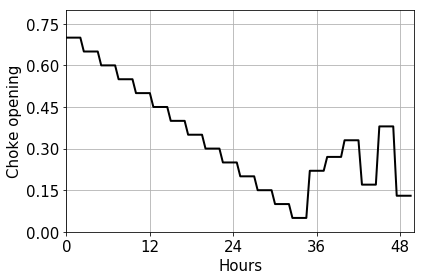

In [26]:
ax = plt.subplot(1, 1, 1)
ax.plot(choke_opening[:100], linewidth = 2, color = 'k')
ax.set_xlabel('Hours', size = 15)
ax.set_xlim(0, 100)
ax.set_ylim(0, 0.8)
ax.set_ylabel('Choke opening', size = 15)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.15))                   
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
x_values = [0, 0,  12, 24, 36, 48]
plt.gca().xaxis.set_ticklabels(x_values, size = 15)

#y-axis
ax.set_ylabel('Choke opening', size = 15)
ax.yaxis.set_tick_params(labelsize = 15)

plt.tight_layout()
ax.grid()

#plt.savefig('Choke.eps', dpi=1000, format='eps')

### Merging choke opening and pressure-temperature data

In [27]:
X_well_test = pd.concat([choke_opening, X_well_test], axis = 1)

In [28]:
#Splitting the well test data based on when the tests were made
total_index = X_well_test.shape[0]
index_1 = round(total_index * 0.25)
index_2 = round(total_index * 0.5)
index_3 = round(total_index * 0.75)

X_1_well_test, y_1_well_test = X_well_test.iloc[:index_1, :], y_well_test.iloc[:index_1 ]
X_2_well_test, y_2_well_test = X_well_test.iloc[index_1 : index_2, :], y_well_test.iloc[index_1 : index_2]
X_3_well_test, y_3_well_test = X_well_test.iloc[index_2 : index_3, :], y_well_test.iloc[index_2 : index_3]
X_4_well_test, y_4_well_test = X_well_test.iloc[index_3 : , :], y_well_test.iloc[index_3 :]

### Case 1 - MPFM

In [29]:
#Case 1.1
X_1_set = X_1
y_1_set = y_1
X_1_ES, X_1_val, y_1_ES, y_1_val = train_test_split(X_1_set, y_1_set, test_size = 0.30, shuffle = False)
X_1_val, X_1_test, y_1_val, y_1_test = train_test_split(X_1_val, y_1_val, test_size = 0.50, shuffle = False)
X_1_CV = pd.concat([X_1_ES, X_1_val], axis = 0, ignore_index = True)
y_1_CV = pd.concat([y_1_ES, y_1_val], axis = 0, ignore_index = True)


#Case 1.2
X_2_set =  pd.concat([X_1, X_2], axis = 0, ignore_index = True) 
y_2_set = pd.concat([y_1, y_2], axis = 0, ignore_index = True)
X_2_ES, X_2_val, y_2_ES, y_2_val = train_test_split(X_2_set, y_2_set, test_size = 0.30, shuffle = False)
X_2_val, X_2_test, y_2_val, y_2_test = train_test_split(X_2_val, y_2_val, test_size = 0.50, shuffle = False)
X_2_CV = pd.concat([X_2_ES, X_2_val], axis = 0, ignore_index = True)
y_2_CV = pd.concat([y_2_ES, y_2_val], axis = 0, ignore_index = True)


#Case 1.3
X_3_set =  pd.concat([X_1, X_2, X_3], axis = 0, ignore_index = True) 
y_3_set = pd.concat([y_1, y_2, y_3], axis = 0, ignore_index = True)
X_3_ES, X_3_val, y_3_ES, y_3_val = train_test_split(X_3_set, y_3_set, test_size = 0.30, shuffle = False)
X_3_val, X_3_test, y_3_val, y_3_test = train_test_split(X_3_val, y_3_val, test_size = 0.50, shuffle = False)
X_3_CV = pd.concat([X_3_ES, X_3_val], axis = 0, ignore_index = True)
y_3_CV = pd.concat([y_3_ES, y_3_val], axis = 0, ignore_index = True)

### Case 2 - MPFM + Well tests

In [30]:
#Case 2.1
X_1_CV_2 = pd.concat([X_1_well_test, X_1_CV, X_2_well_test], axis = 0, ignore_index = True)
y_1_CV_2 = pd.concat([y_1_well_test, y_1_CV, y_2_well_test], axis = 0, ignore_index = True)

X_1_ES_2 = pd.concat([X_1_well_test, X_1_ES, X_2_well_test], axis = 0, ignore_index = True)
y_1_ES_2 = pd.concat([y_1_well_test, y_1_ES, y_2_well_test], axis = 0, ignore_index = True)


#Case 2.2
X_2_train, X_2_test_fake, y_2_train, y_2_test_fake = train_test_split(X_2, y_2, test_size = 0.60, shuffle = False)
X_2_val_fake, X_2_test_fake, y_2_val_fake, y_2_test_fake = train_test_split(X_2_test_fake, y_2_test_fake, test_size = 0.50, shuffle = False)

X_2_ES_2 = pd.concat([X_1_well_test, X_1, X_2_well_test, X_2_train, X_3_well_test], axis = 0, ignore_index = True)
y_2_ES_2 = pd.concat([y_1_well_test, y_1, y_2_well_test, y_2_train, y_3_well_test], axis = 0, ignore_index = True)

X_2_CV_2 = pd.concat([X_1_well_test, X_1, X_2_well_test, X_2_train, X_2_val_fake, X_3_well_test], axis = 0, ignore_index = True)
y_2_CV_2 = pd.concat([y_1_well_test, y_1, y_2_well_test, y_2_train, y_2_val_fake, y_3_well_test], axis = 0, ignore_index = True)


#Case 2.3
X_3_train, X_3_test_fake, y_3_train, y_3_test_fake = train_test_split(X_3, y_3, test_size = 0.90, shuffle = False)
X_3_val_fake, X_3_test_fake, y_3_val_fake, y_3_test_fake = train_test_split(X_3_test_fake, y_3_test_fake, test_size = 0.50, shuffle = False)

X_3_ES_2 = pd.concat([X_1_well_test, X_1, X_2_well_test, X_2, X_3_well_test, X_3_train, X_4_well_test], axis = 0, ignore_index = True)
y_3_ES_2 = pd.concat([y_1_well_test, y_1, y_2_well_test, y_2, y_3_well_test, y_3_train, y_4_well_test], axis = 0, ignore_index = True)

X_3_CV_2 = pd.concat([X_1_well_test, X_1, X_2_well_test, X_2, X_3_well_test, X_3_train, X_3_val_fake, X_4_well_test], axis = 0, ignore_index = True)
y_3_CV_2 = pd.concat([y_1_well_test, y_1, y_2_well_test, y_2, y_3_well_test, y_3_train, y_3_val_fake, y_4_well_test], axis = 0, ignore_index = True)

## Case 3

In [31]:
X_1_train, y_1_train = X_1_well_test, y_1_well_test
X_2_train, y_2_train = pd.concat([X_1_well_test, X_2_well_test], axis = 0), pd.concat([y_1_well_test, y_2_well_test], axis = 0)
X_3_train, y_3_train = pd.concat([X_1_well_test, X_2_well_test, X_3_well_test], axis = 0), pd.concat([y_1_well_test, y_2_well_test, y_3_well_test], axis = 0)
X_4_train, y_4_train = pd.concat([X_1_well_test, X_2_well_test, X_3_well_test, X_4_well_test], axis = 0), pd.concat([y_1_well_test, y_2_well_test, y_3_well_test, y_4_well_test], axis = 0)

## Plotting the data

### Target variable

In [32]:
y_total = np.concatenate((y_1_well_test, y_1, y_2_well_test, y_2, y_3_well_test, y_3, y_4_well_test, y_4), axis = 0)
y_total.shape

(2590, 1)

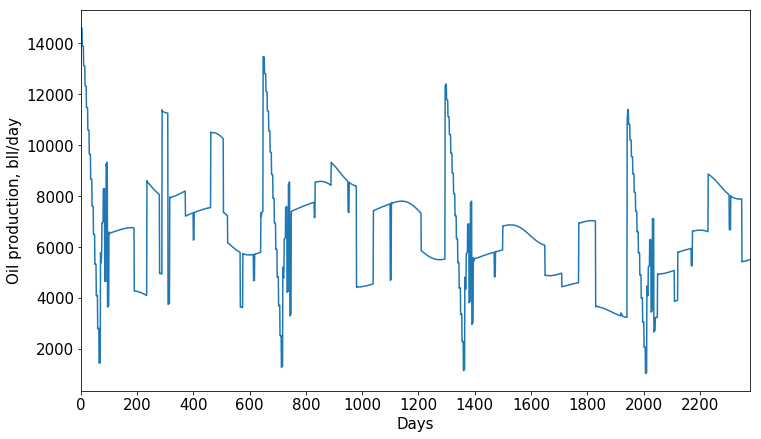

In [33]:
plt.figure(figsize = (12, 7))
plt.xlabel('Days', size = 15)
plt.xticks(np.arange(0, 3000, step = 200), size = 15)
plt.ylabel('Oil production, bll/day', size = 15)
plt.yticks(size = 15)
plt.xlim(0, 2380)
plt.plot(y_total)

### Comparison of true production profile and measurements from multiphase flow meter

MAE error between the truth and MPFM is 202.96023169599195
MAPE error between the truth and MPFM is 3.1616898550705654


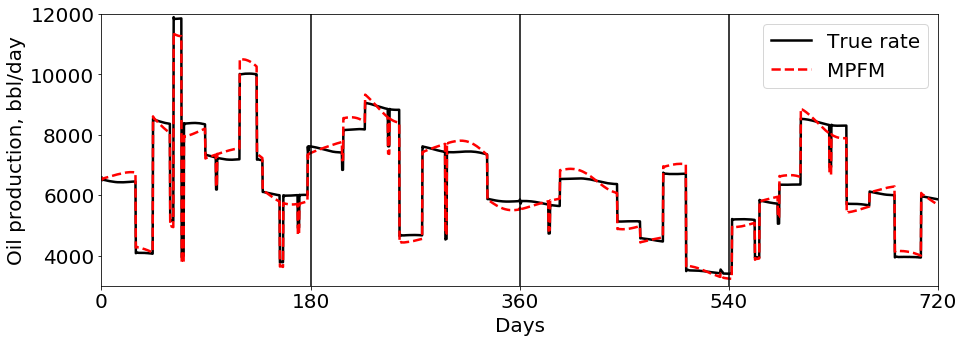

In [37]:
fig, ax = plt.subplots(figsize = (15, ))

ax.plot(data[['oil_rate_bbl']].values, label = 'True rate', linewidth = 2.5, color = 'k')
ax.plot(data[['oil_rate_meter']].values, label = 'MPFM', linewidth = 2.5, linestyle = '--', color = 'r')
ax.legend(fontsize = 20)

#x-axis
ax.set_xlabel('Days', size = 20)
ax.set_xlim(0, 2190)
ax.xaxis.set_major_locator(ticker.MultipleLocator(547))
x_values = [0, 0,  180, 360, 540, 720]
plt.gca().xaxis.set_ticklabels(x_values, size = 20)

#y-axis
ax.set_ylabel('Oil production, bbl/day', size = 20)
ax.yaxis.set_tick_params(labelsize = 20)

plt.yticks(size = 20)
plt.xlim(0, 2190)
plt.ylim(3000, 12000)

x_1_plot = [547, 547]
y_1_plot = [0, 12000]

x_2_plot = [1095, 1095]
y_2_plot = [0, 12000]

x_3_plot = [1641, 1641]
y_3_plot = [0, 12000]
plt.plot(x_1_plot, y_1_plot, x_2_plot, y_2_plot, x_3_plot, y_3_plot, color = 'k')

print ('MAE error between the truth and MPFM is', mean_absolute_error(data[['oil_rate_bbl']].values, 
                                                                      data[['oil_rate_meter']].values))
print ('MAPE error between the truth and MPFM is', mean_absolute_percentage_error(data[['oil_rate_bbl']].values, data[['oil_rate_meter']].values))

plt.savefig('Profile.jpg', dpi=600, format='jpg')

# Algorithm learning and tuning

### Parameters explanation

- __min_child_weight__ - Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node.

- __gamma__ - Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.

- __subsample__ - Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.

- __colsample_bytree__ - Subsample ratio of columns when constructing each tree. Subsampling will occur once in every boosting iteration (range: (0,1]).

- __max_depth__ - Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.

## Function for hyperparametres selection

In [17]:
def Random_search_selection(features_cv, target_cv, features_es, target_es, features_val, target_val, features_test, 
                            target_test, features_eval, target_eval, early_stopping_check = None, error_type = 'mae', 
                            num_of_steps = 25, cv_number = 3, learn_rate = 0.1, fraction = 0.8, max_estim_num = 100, 
                            depth_limit = 7):
    """
    Dataset parameters (features_ - training datasets (features), target_ - target datasets)
    -----------------------------------------------------------------
    features_cv - train dataset for K-fold cross-validation
    target_cv - target values for "features_cv"
    features_es - train dataset for early-stopping
    target_es - target values for "features_es"
    features_val - validation dataset for early stopping
    target_val - target values for "features_val"
    features_test - test dataset
    target_test - target values for "features_test"
    features_eval - evaluation dataset for K-fold cross-validation and early-stopping
    target_eval - target values for "features_eval"
    
    Tuning parameters
    -----------------------------------------------------------------
    early_stop_check - choose if want to perform early stopping
    num_of_steps - number of randomized searches
    cv_number - number of performed cross-validations
    learn_rate - learning_rate
    fraction - value for "subsample" parametre in XGBoost
    max_estim_num - limit maximum number of estimators
    depth_lim - limit for "max_depth" XGBoost parameter
    
    Returns
    ------------------------------------------------------------------
    total_list_cv - list with best parameters from "num_of_steps" randomized searches with cross-validation only 
    total_list_additional - list with best parameters from "num_of_steps" randomized searches with cross-validation and early stopping
    """
    #Converting training data to numpy arrays for further training
    features_cv = np.array(features_cv)
    target_cv = np.array(target_cv)
    features_test = np.array(features_test) 
    target_test = np.array(target_test)
    features_eval = np.array(features_eval)
    target_eval = np.array(target_eval)
    #Creating a dictionary with empty lists for hyperparameters. These lists will then be used to store 
    #the best hyperparameters from each run of randomized seach
   #param_list = ['min_child_weight', 'reg_lambda', 'gamma', 'max_depth', 'n_estimators', 'best_estim_num']
    param_list = ['min_child_weight', 'reg_lambda', 'gamma', 'max_depth', 'n_estimators']
    param_dict_cv = {}
    param_dict_es = {}
    for parameter in param_list:
        param_dict_cv[parameter + '_list_cv'] = [] 
        param_dict_es[parameter + '_list_es'] = []
    #Creating a dictionary with empty lists for errors on train, test and evaluation datasets. These lists will then 
    #be used to store errors associated with a hyperparameters sets
    error_list = ['train', 'test', 'eval']
    error_dict_cv = {}
    error_dict_es = {}
    for error in error_list:
        error_dict_cv['mae_' + error + '_cv_list'] = []
        error_dict_es['mae_' + error + '_es_list'] = []
    #Create functions with error types which we would like to use for evaluation of the hyperparameters
    if error_type == 'mape':
        def error(y_true, y_pred): 
            return np.mean(100 * np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true)))
    elif error_type == 'mae':
        def error(y_true, y_pred): 
            return mean_absolute_error(y_true, y_pred)
    ################################################# Parameters space ####################################################
    rand_seed = 100 #The seed is changed to another value for the next Random search
    #For a specified number of random searches each time we perform a search which returns best hyperparameters 
    #which are selected based on K-Fold cross-validation
    for i in range(num_of_steps):  
        params = {
                'min_child_weight': np.arange(1, 8, 1),
                'reg_lambda': np.linspace(0.1, 20, num = 100),
                'gamma': st.uniform(0.1, 20),
                'max_depth': st.randint(1, depth_limit),
                'n_estimators': st.randint(25, max_estim_num)
                }
        
        #We can choose to performccross-validation or not. If not, the algorithm chooses the case when the error on the train
        #set is the smallest. This is achieved by [(slice(None), slice(None))]
        if cv_number is not None:
            CV_KFold = TimeSeriesSplit(n_splits = cv_number)
            #CV_KFold = KFold(n_splits = cv_number, shuffle = False, random_state = np.random.seed(rand_seed))  
        else:
            CV_KFold = [(slice(None), slice(None))]
            
        #Define the model with the fixed learning rate and Random Search with the specified parameters' space
        model = xgb.XGBRegressor(learning_rate = learn_rate, subsample = fraction, colsample_bytree = 1, objective = 'reg:linear')
        clf = RandomizedSearchCV(model, param_distributions = params, n_jobs = 1, scoring = 'neg_mean_absolute_error', 
                                 n_iter = 10, refit = True, cv = CV_KFold, random_state = np.random.seed(rand_seed))
        
        ########################################### Case with cross validation only ###########################################
        #Fit the regressor with Cross-validation and obtain the best parameters
        clf.fit(features_cv, target_cv)
        best_parameters, score = clf.best_params_, clf.best_score_
        #Make predictions on train, test and evaluation sets with the best obtained regressor 
        preds_train_cv, preds_test_cv, preds_eval_cv  = clf.predict(features_cv), clf.predict(features_test), clf.predict(features_eval)
        #Compute the errors on the datasets and append to the lists in the error dictionaries. 
        #These errors are further used for regressor bias-variance evaluation
        error_dict_cv['mae_train_cv_list'].append(error(target_cv, preds_train_cv)) #Error on train set
        error_dict_cv['mae_test_cv_list'].append(error(target_test, preds_test_cv)) #Error on test set
        error_dict_cv['mae_eval_cv_list'].append(error(target_eval, preds_eval_cv)) #Error on evaluation set
        #Appending the values of the best obtained parameters
        for parameter in param_list:
            param_dict_cv[parameter + '_list_cv'].append(best_parameters[str(parameter)])
        #Finilizing the list with the results
        total_list_cv = error_dict_cv['mae_eval_cv_list'] + error_dict_cv['mae_test_cv_list'] + \
        error_dict_cv['mae_train_cv_list'] + param_dict_cv['n_estimators_list_cv'] +  param_dict_cv['min_child_weight_list_cv'] +  \
        param_dict_cv['reg_lambda_list_cv'] + param_dict_cv['gamma_list_cv'] +  param_dict_cv['max_depth_list_cv']
          
        ################################################## Early stopping ###################################################### 
        if early_stopping_check is not None: 
            #Converting data to numpy arrays
            features_es = np.array(features_es)
            target_es = np.array(target_es)
            features_val = np.array(features_val)
            target_val = np.array(target_val)
            
            best_error = 10000 #Assign an error to a big value so any result from training would be better. Needed to start the loop
            rand_seed_es = rand_seed
            for i in range(10):
                rand_seed_es += 1
                #Create list of hyperparametres randomly samples from the parameters distributions using ParametreSampler
                #It returns ['gamma':.., 'max_depth': .., 'min_child_weight': .., 'n_estimators': .., 'reg_lambda':..]
                param_list_es = list(ParameterSampler(params, n_iter = 1, random_state = rand_seed_es))
                #Fit the model with the random parameters from param_list. The model returns the best model obtained with
                #early stopping on the features_val dataset
                model_2 = xgb.XGBRegressor(learning_rate = learn_rate, subsample = fraction, colsample_bytree = 1, 
                                       n_estimators =  100, gamma = param_list_es[0]['gamma'], 
                                       reg_lambda = param_list_es[0]['reg_lambda'], max_depth = param_list_es[0]['max_depth'], 
                                       min_child_weight = param_list_es[0]['min_child_weight'])
                model_2.fit(features_es, target_es, eval_set = [(features_val, target_val)], eval_metric = 'mae', 
                        early_stopping_rounds = 5, verbose = 50)
            
                #Make predictions on the train, test and evaludation sets with the best obtained model
                preds_train_es, preds_test_es = model_2.predict(features_es), model_2.predict(features_test) 
                preds_eval_es = model_2.predict(features_eval)
                #Compute the error and choose if the error is less than the error from previous iteration
                model_error = error(target_test, preds_test_es)
                if model_error < best_error: #If the test error is the best, we save the associated errors for future comparison
                    best_error = model_error
                    train_error_es = error(target_es, preds_train_es)
                    test_error_es = error(target_test, preds_test_es)
                    eval_error_es = error(target_eval, preds_eval_es)
            #Compute the errors on the datasets and append to the lists in the error dictionaries. 
            #These errors are further used for regressor bias-variance evaluation
            error_dict_es['mae_train_es_list'].append(train_error_es) #Error on train set
            error_dict_es['mae_test_es_list'].append(test_error_es) #Error on test set
            error_dict_es['mae_eval_es_list'].append(eval_error_es) #Error on evaluation set          
            #Appending the values of the best obtained parameters
            for parameter in param_list:
                param_dict_es[parameter + '_list_es'].append(param_list_es[0][str(parameter)])
            param_dict_es['n_estimators'] = model_2.best_iteration + 1 #+1 because iterations are counted from 0

            #Finilizing the list with the results
            total_list_es = error_dict_es['mae_eval_es_list'] + error_dict_es['mae_test_es_list'] + \
            error_dict_es['mae_train_es_list'] + param_dict_es['n_estimators_list_es'] +  param_dict_es['min_child_weight_list_es'] +  \
            param_dict_es['reg_lambda_list_es'] + param_dict_es['gamma_list_es'] +  param_dict_es['max_depth_list_es']
        
        rand_seed += 1 #Change seed generator to test another set of parameters
    
    if early_stopping_check is not None:
        return total_list_cv, total_list_es
    else:
        return total_list_cv

In [18]:
def plot_function(y_true_train, y_pred_train, y_true_test, y_MPFM_test, y_pred_test):
    fig = plt.figure(figsize = (20, 8))
    fig.suptitle('Each point corresponds 8 hours of production', fontsize=20)
    #Training set
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(np.array(y_true_train), label = 'True rate', linewidth = 2.5)
    ax1.plot(y_pred_train, label = 'XGBoost', linewidth = 2.5)
    ax1.set_title('Training test', size = 30)
    ax1.legend(fontsize = 25)
    ax1.set_xlim(0, y_true_train.shape[0])
    ax1.set_xlabel('Production point (8 hours)', size = 25)
    ax1.set_ylabel('Oil production, bbl/day', size = 25)
    ax1.xaxis.set_tick_params(labelsize = 25)
    ax1.yaxis.set_tick_params(labelsize = 25)
    
    #Evaluation dataset
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(np.array(y_true_test), label = 'True rate', linewidth = 3)
    ax2.plot(np.array(y_MPFM_test), label = 'MPFM', linewidth = 2.5, color = 'k')
    ax2.plot(y_pred_test, label = 'XGBoost', linewidth = 2.5, linestyle = '--', color = 'r')
    ax2.legend(fontsize = 20)
    ax2.set_title('Evaluation set', size = 30)
    ax2.set_xlabel('Production point (8 hours)', size = 25)
    ax2.set_ylabel('Oil production, bbl/day', size = 25)
    ax2.set_xlim(0, y_pred_test.shape[0])
    ax2.xaxis.set_tick_params(labelsize = 25)
    ax2.yaxis.set_tick_params(labelsize = 25)
    plt.tight_layout()
    plt.show()

# Case 1

In [19]:
#Parameters for case 1.1
STEP_NUM = 10
RATE = 0.1
FRACTION = 1
MAX_ESTIM = 40
MAX_DEPTH = 7

# Case 1.1 simulation

In [20]:
%%time
output_cv_1, output_stopping_1 = Random_search_selection(features_cv = X_1_CV, target_cv = y_1_CV, features_es = X_1_ES, 
                                                         target_es = y_1_ES, features_val = X_1_val, target_val = y_1_val, 
                                                         features_test = X_1_test, target_test = y_1_test, features_eval = X_2, 
                                                         target_eval = y_2,  early_stopping_check = 'Yes', error_type = 'mae', 
                                                         num_of_steps = STEP_NUM, cv_number = 5, learn_rate = RATE, 
                                                         fraction = FRACTION, max_estim_num = MAX_ESTIM, depth_limit = MAX_DEPTH)

[0]	validation_0-mae:6574.38
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:247.374
Stopping. Best iteration:
[45]	validation_0-mae:241.539

[0]	validation_0-mae:6573.52
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[41]	validation_0-mae:232.674

[0]	validation_0-mae:6572.22
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[41]	validation_0-mae:259.524

[0]	validation_0-mae:6558.04
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[37]	validation_0-mae:283.841

[0]	validation_0-mae:6569.6
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[42]	validation_0-mae:244.806

[0]	validation_0-mae:6573.95
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[41]	validation_0-mae:237.086

[0]	validation_0-mae:6574.38
Will train until validation_0-mae hasn't improve

Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:275.696
Stopping. Best iteration:
[47]	validation_0-mae:267.772

[0]	validation_0-mae:6509.74
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[35]	validation_0-mae:297.156

[0]	validation_0-mae:6562.08
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[38]	validation_0-mae:268.657

[0]	validation_0-mae:6588.1
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[38]	validation_0-mae:263.522

[0]	validation_0-mae:6571.78
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:295.241
Stopping. Best iteration:
[50]	validation_0-mae:295.241

[0]	validation_0-mae:6533.35
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[33]	validation_0-mae:279.849

[0]	validation_0-mae:6577.4
Will train until validation_0-mae hasn't improve

# Case 1.1 results

## Cross validation

In [21]:
final_scores_random = np.array(output_cv_1).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mae_eval', 'mae_test', 'mae_train', 'n_estimators', 'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval,mae_test,mae_train,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,470.510297,183.656479,132.194428,39.0,6.0,1.306061,15.291901,2.0
1,423.711342,173.248019,153.963841,38.0,2.0,2.914141,18.900596,2.0
2,400.380977,137.881826,155.017682,38.0,3.0,3.517172,1.211411,5.0
3,416.162597,164.945583,158.334112,37.0,7.0,1.105051,18.429742,2.0
4,399.821510,126.144667,183.823691,36.0,5.0,2.713131,9.151441,6.0


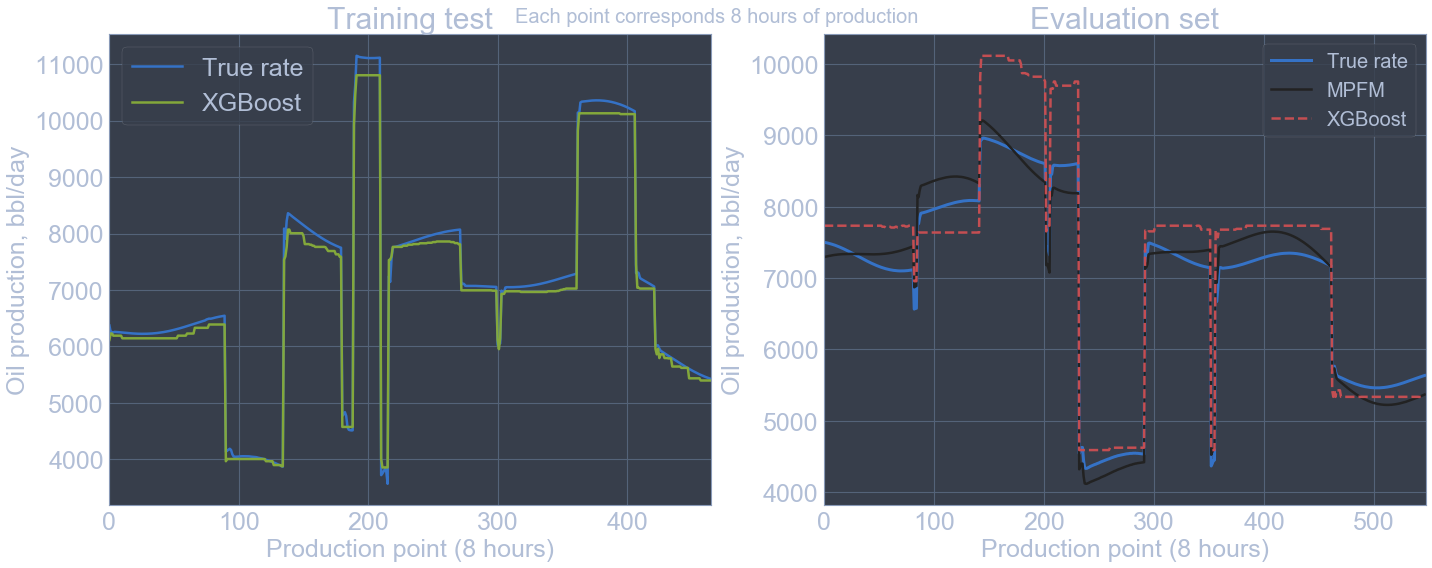

MAE XGBoost error in training is 132.19442771127143
MAPE MPFM error relative to truth in evaluation is 3.144904588021033
MAPE XGBoost error relative to truth in training is 1.8030042175550456
MAPE XGBoost error relative to truth in evaluation is 6.410451878267147


In [22]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, n_estimators =  int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), min_child_weight = final_score['min_child_weight'][0])

#Checking the obtained error 
clf.fit(np.array(X_1_CV), np.array(y_1_CV))
predict_train = clf.predict(np.array(X_1_CV)) #Error on training set
predict_eval = clf.predict(np.array(X_2)) #Error on the evaluation set

#Plotting
#plot_importance(clf) #Can also plot feature importance for XGBoost
plot_function(y_true_train=y_1_CV, y_pred_train=predict_train, y_true_test=y_2_true, y_MPFM_test=y_2, y_pred_test=predict_eval )

print ('MAE XGBoost error in training is', mean_absolute_error(y_1_CV, predict_train))
print ('MAPE MPFM error relative to truth in evaluation is', mean_absolute_percentage_error(y_2_true.values, y_2_meter.values))
print ('MAPE XGBoost error relative to truth in training is', mean_absolute_percentage_error(y_1_CV, predict_train.reshape(y_1_CV.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', mean_absolute_percentage_error(y_2_true.values, predict_eval.reshape(y_2_true.shape[0], 1)))

## Early stopping

In [23]:
final_scores_random = np.array(output_stopping_1).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key = lambda column: column[2]), 
                           columns = ['mape_eval_stopping', 'mape_test_stopping', 'mape_train_stopping', 'n_estimators', \
                                      'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mape_eval_stopping,mape_test_stopping,mape_train_stopping,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,547.518817,580.222485,139.82226,37.0,4.0,16.582828,3.132639,3.0
1,547.518817,580.222485,139.82226,25.0,7.0,18.391919,4.021846,3.0
2,547.518817,580.222485,139.82226,26.0,7.0,9.346465,7.603373,5.0
3,547.518817,580.222485,139.82226,32.0,2.0,3.919192,9.128223,1.0
4,547.518817,580.222485,139.82226,36.0,6.0,1.909091,18.953031,4.0


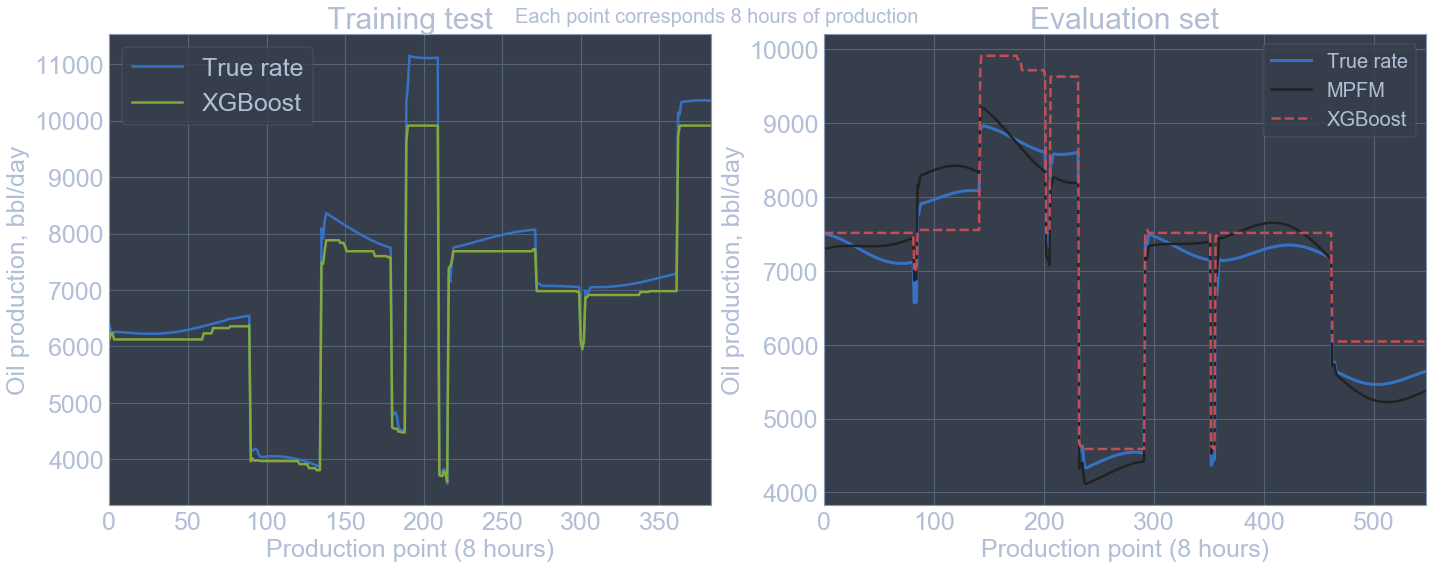

MAE XGBoost error in training is 241.0020728470575
MAPE XGBoost error in test set is 9.339104072314534
MAPE XGBoost error relative to truth in evaluation is 5.814996060664322


In [24]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, n_estimators =  int(final_score['n_estimators'][0]), 
                           gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), min_child_weight = final_score['min_child_weight'][0])
            
#Checking the obtained error 
clf.fit(np.array(X_1_ES), np.array(y_1_ES))
predict_train = clf.predict(np.array(X_1_ES))
predict_test = clf.predict(np.array(X_1_test))
predict_eval = clf.predict(np.array(X_2))

#Plotting
plot_function(y_true_train=y_1_ES, y_pred_train=predict_train, y_true_test=y_2_true, y_MPFM_test=y_2, y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_1_ES, predict_train))
print ('MAPE XGBoost error in test set is', mean_absolute_percentage_error(y_1_test.values, predict_test.reshape(y_1_test.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', mean_absolute_percentage_error(y_2_true.values, predict_eval.reshape(y_2_true.shape[0], 1)))

## Case 1.2

In [25]:
#Parameters for case 1.1
STEP_NUM = 10
RATE = 0.1
FRACTION = 1
MAX_ESTIM = 37 #37
MAX_DEPTH = 6

In [26]:
%%time
output_cv_2, output_stopping_2 = Random_search_selection(features_cv = X_2_CV, target_cv = y_2_CV, features_es = X_2_ES, 
                                                         target_es = y_2_ES, features_val = X_2_val, target_val = y_2_val, 
                                                         features_test = X_2_test, target_test = y_2_test, features_eval = X_3, 
                                                         target_eval = y_3,  early_stopping_check = 'Yes', error_type = 'mae', 
                                                         num_of_steps = STEP_NUM, cv_number = 5, learn_rate = RATE, 
                                                         fraction = FRACTION, max_estim_num = MAX_ESTIM, depth_limit = MAX_DEPTH)

[0]	validation_0-mae:5577.98
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[30]	validation_0-mae:104.784

[0]	validation_0-mae:5577.33
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[38]	validation_0-mae:91.1804

[0]	validation_0-mae:5572.24
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:100.808
Stopping. Best iteration:
[62]	validation_0-mae:95.2142

[0]	validation_0-mae:5610.72
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[28]	validation_0-mae:108.803

[0]	validation_0-mae:5565.51
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	validation_0-mae:102.714

[0]	validation_0-mae:5577.66
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	validation_0-mae:104.482

[0]	validation_0-mae:5617.56
Will train until validation_0-mae hasn't improv

[0]	validation_0-mae:5544.81
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[27]	validation_0-mae:150.272

[0]	validation_0-mae:5608.04
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	validation_0-mae:112.025

[0]	validation_0-mae:5639.02
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:114.38
Stopping. Best iteration:
[55]	validation_0-mae:111.863

[0]	validation_0-mae:5571.91
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[27]	validation_0-mae:135.575

[0]	validation_0-mae:5641.17
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:95.9562
Stopping. Best iteration:
[55]	validation_0-mae:93.0892

[0]	validation_0-mae:5629.64
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:127.102
Stopping. Best iteration:
[49]	validation_0-mae:124.532

[0]	validation_0-

## Cross validation

In [27]:
final_scores_random = np.array(output_cv_2).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mae_eval', 'mae_test', 'mae_train', 'n_estimators', 'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval,mae_test,mae_train,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,346.920074,233.914937,177.388679,36.0,5.0,2.512121,17.435145,3.0
1,367.594962,202.074791,181.258634,36.0,1.0,2.914141,11.579121,2.0
2,388.044678,237.221039,188.829760,36.0,4.0,5.125253,14.918589,2.0
3,344.651108,279.687397,233.841147,33.0,7.0,1.105051,18.429742,2.0
4,307.281091,271.436764,234.025692,33.0,1.0,2.914141,20.018091,4.0


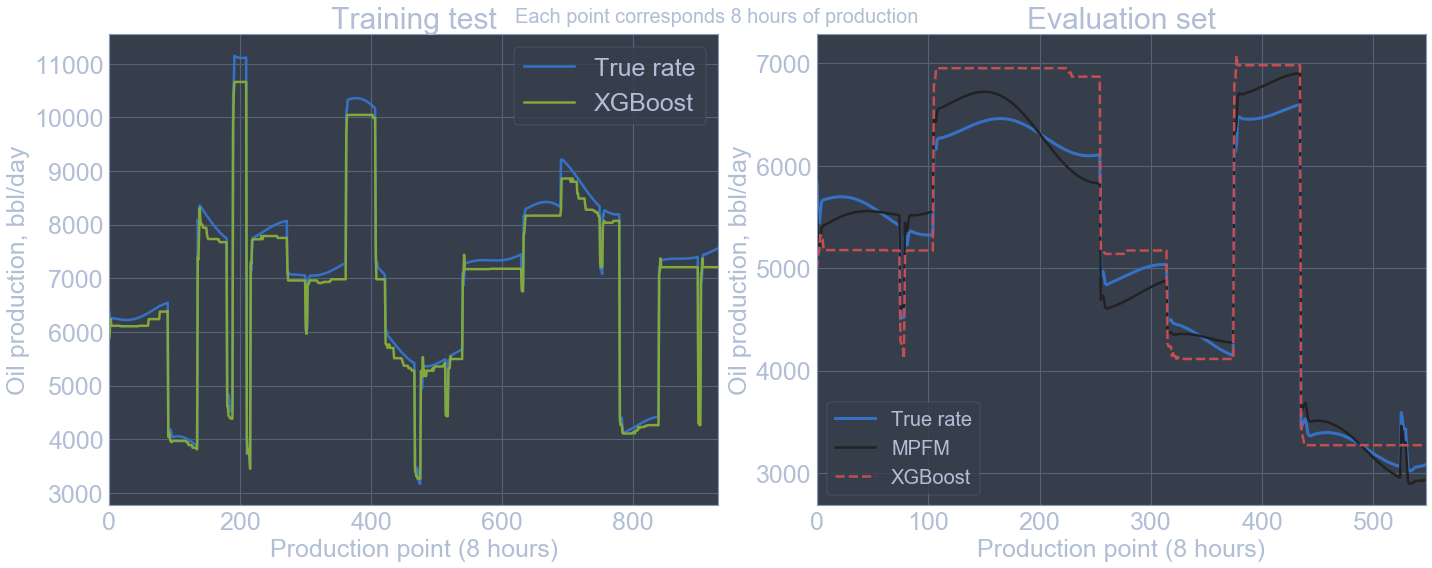

MAE XGBoost error in training is 177.38867915592385
MAPE MPFM error relative to truth in evaluation is 3.0910962571801877
MAPE XGBoost error relative to truth in training is 2.4858459313606187
MAPE XGBoost error relative to truth in evaluation is 6.610458666726811


In [28]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, n_estimators =  int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), min_child_weight = final_score['min_child_weight'][0])

#Checking the obtained error       
clf.fit(np.array(X_2_CV), np.array(y_2_CV))
predict_train = clf.predict(np.array(X_2_CV))
predict_eval = clf.predict(np.array(X_3))

#Plotting
plot_function(y_true_train=y_2_CV, y_pred_train=predict_train, y_true_test=y_3_true, y_MPFM_test=y_3, y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_2_CV, predict_train))
print ('MAPE MPFM error relative to truth in evaluation is', mean_absolute_percentage_error(y_3_true.values, y_3_meter.values))
print ('MAPE XGBoost error relative to truth in training is', mean_absolute_percentage_error(y_2_CV, predict_train.reshape(y_2_CV.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', mean_absolute_percentage_error(y_3_true.values, predict_eval.reshape(y_3_true.shape[0], 1)))

## Early stopping

In [29]:
final_scores_random = np.array(output_stopping_2).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mae_eval_stopping', 'mae_test_stopping', \
                                      'mae_train_stopping', 'n_estimators', \
                                      'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval_stopping,mae_test_stopping,mae_train_stopping,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,304.634425,139.993529,53.237162,27.0,3.0,4.522222,17.139710,3.0
1,304.634425,139.993529,53.237162,27.0,4.0,1.909091,3.132639,3.0
2,304.634425,139.993529,53.237162,25.0,7.0,18.391919,4.021846,3.0
3,304.634425,139.993529,53.237162,26.0,7.0,9.346465,7.603373,5.0
4,304.634425,139.993529,53.237162,32.0,2.0,3.919192,9.128223,1.0


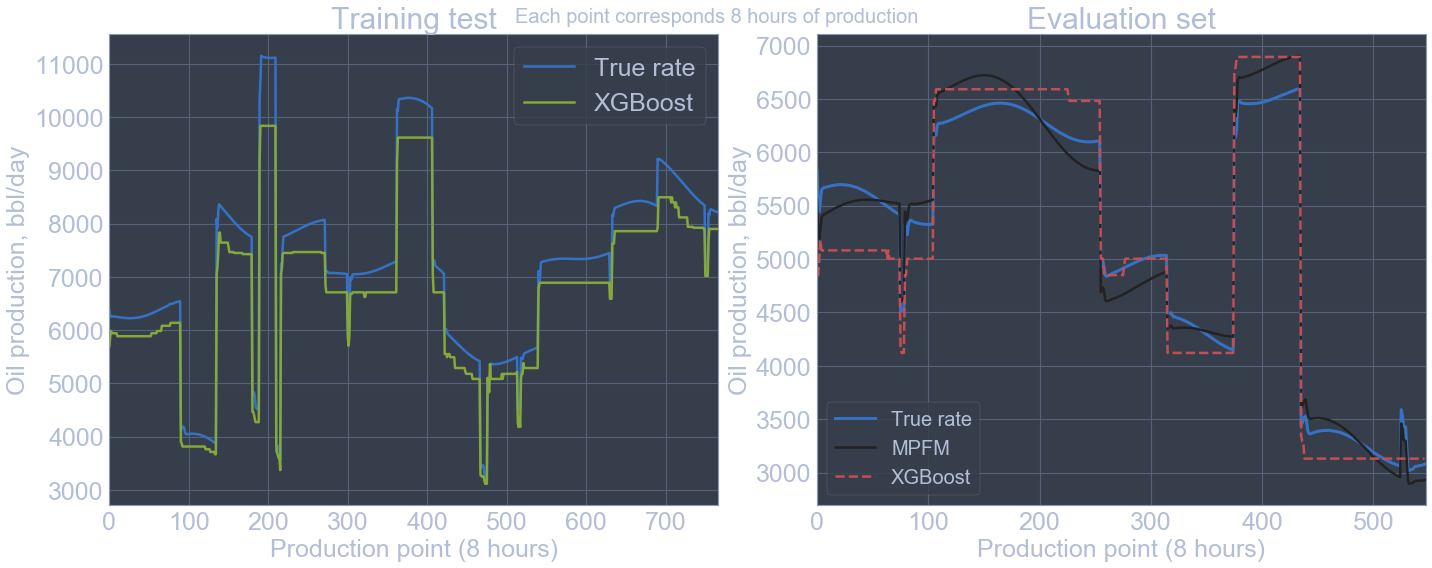

MAE XGBoost error in training is 450.5131546737025
MAPE XGBoost error in test set is 6.133763588738547
MAPE XGBoost error relative to truth in evaluation is 5.114176638222208


In [30]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, n_estimators =  int(final_score['n_estimators'][0]), 
                           gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), min_child_weight = final_score['min_child_weight'][0])
            
#clf.fit(np.array(X_1_train), np.array(y_1_train))
clf.fit(np.array(X_2_ES), np.array(y_2_ES))
predict_train = clf.predict(np.array(X_2_ES))
predict_test = clf.predict(np.array(X_2_test))
predict_eval = clf.predict(np.array(X_3))

#Plotting
plot_function(y_true_train=y_2_ES, y_pred_train=predict_train, y_true_test=y_3_true, y_MPFM_test=y_3, y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_2_ES, predict_train))
print ('MAPE XGBoost error in test set is', mean_absolute_percentage_error(y_2_test.values, predict_test.reshape(y_2_test.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', mean_absolute_percentage_error(y_3_true.values, predict_eval.reshape(y_3_true.shape[0], 1)))

## Case 1.3

In [31]:
STEP_NUM = 10
RATE = 0.1
FRACTION = 1
MAX_ESTIM = 40
MAX_DEPTH = 6

In [32]:
%%time
output_cv_3, output_stopping_3 = Random_search_selection(features_cv = X_3_CV, target_cv = y_3_CV, features_es = X_3_ES, 
                                                         target_es = y_3_ES, features_val = X_3_val, target_val = y_3_val, 
                                                         features_test = X_3_test, target_test = y_3_test, features_eval = X_4, 
                                                         target_eval = y_4,  early_stopping_check = 'Yes', error_type = 'mae', 
                                                         num_of_steps = STEP_NUM, cv_number = 5, learn_rate = RATE, 
                                                         fraction = FRACTION, max_estim_num = MAX_ESTIM, depth_limit = MAX_DEPTH)

[0]	validation_0-mae:5215.68
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[23]	validation_0-mae:330.553

[0]	validation_0-mae:5213.38
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[23]	validation_0-mae:324.805

[0]	validation_0-mae:5212.73
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[23]	validation_0-mae:329.703

[0]	validation_0-mae:5189.93
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:324.711

[0]	validation_0-mae:5211.41
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[23]	validation_0-mae:326.002

[0]	validation_0-mae:5213.6
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:330.838

[0]	validation_0-mae:5215.68
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best 

Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:325.167

[0]	validation_0-mae:5212.51
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:323.183

[0]	validation_0-mae:5226.9
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[24]	validation_0-mae:325.449

[0]	validation_0-mae:5217.2
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:324.674

[0]	validation_0-mae:5219.14
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:327.221

[0]	validation_0-mae:5215.68
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[23]	validation_0-mae:330.553

[0]	validation_0-mae:5218.06
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-m

## Cross validation

In [33]:
final_scores_random = np.array(output_cv_3).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mae_eval', 'mae_test', 'mae_train', 'n_estimators', 'min_child_weight', 
                                      'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval,mae_test,mae_train,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,231.618576,164.770271,136.429462,39.0,3.0,6.934343,3.234222,3.0
1,211.229805,180.933712,138.257369,38.0,3.0,3.517172,1.211411,5.0
2,228.718796,179.829534,158.966990,37.0,6.0,5.929293,5.077554,5.0
3,344.503136,202.534003,163.118935,36.0,7.0,1.909091,12.967298,5.0
4,208.434312,205.858720,183.906778,36.0,4.0,11.155556,16.652645,5.0


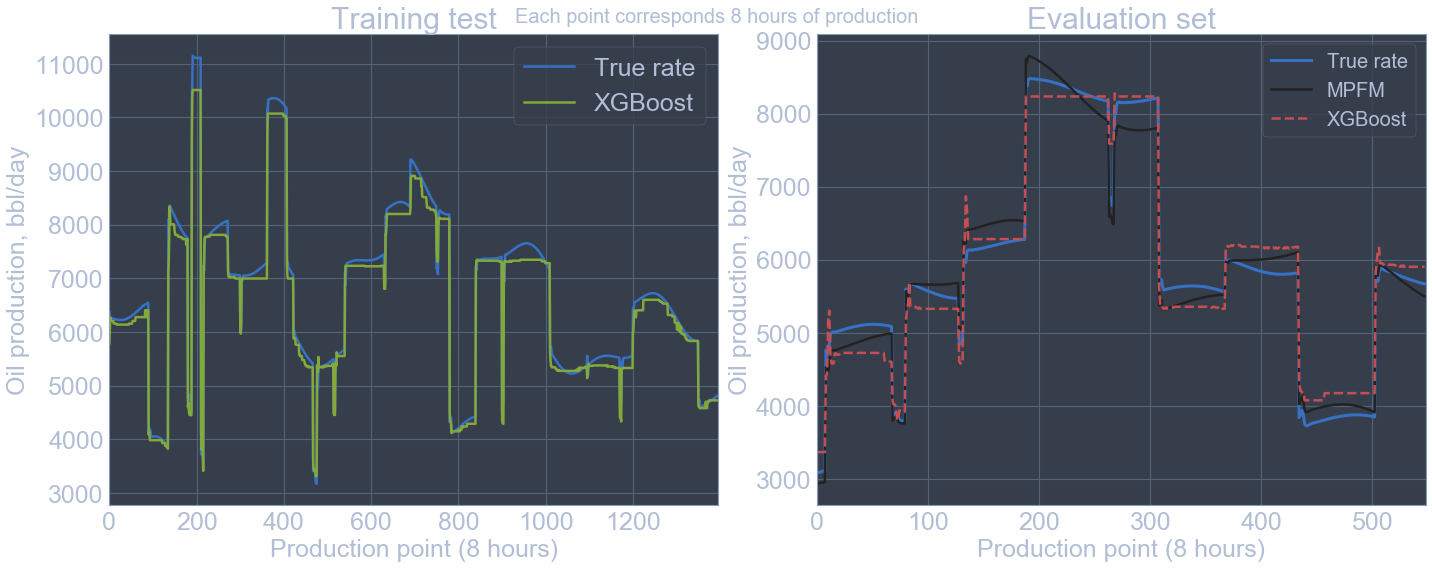

MAE XGBoost error in training is 136.42946236906334
MAPE MPFM error relative to truth in evaluation is 3.138006955866615
MAPE XGBoost error relative to truth in training is 1.9789785304278353
MAPE XGBoost error relative to truth in evaluation is 4.376621522815836


In [34]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, n_estimators =  int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), min_child_weight = final_score['min_child_weight'][0])

#Checking the obtained error       
clf.fit(np.array(X_3_CV), np.array(y_3_CV))
predict_train = clf.predict(np.array(X_3_CV))

#Computing the error on the evaluation set
predict_eval = clf.predict(np.array(X_4))

#Plotting
plot_function(y_true_train=y_3_CV, y_pred_train=predict_train, y_true_test=y_4_true, y_MPFM_test=y_4, y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_3_CV, predict_train))
print ('MAPE MPFM error relative to truth in evaluation is', mean_absolute_percentage_error(y_4_true.values, y_4_meter.values))
print ('MAPE XGBoost error relative to truth in training is', mean_absolute_percentage_error(y_3_CV, predict_train.reshape(y_3_CV.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', mean_absolute_percentage_error(y_4_true.values, predict_eval.reshape(y_4_true.shape[0], 1)))

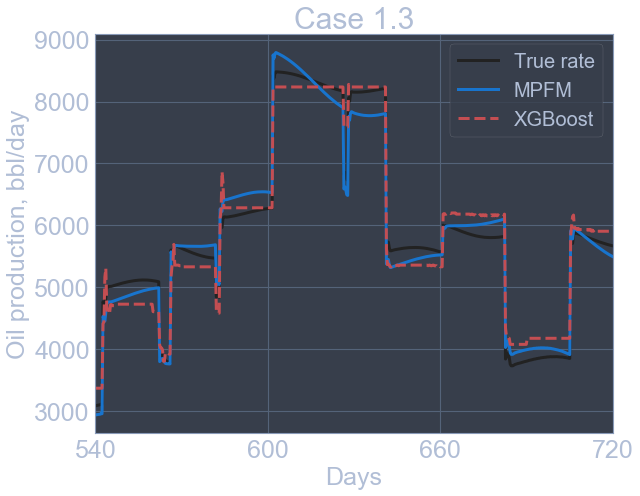

In [35]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, n_estimators =  int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), min_child_weight = final_score['min_child_weight'][0])

#Checking the obtained error       
clf.fit(np.array(X_3_CV), np.array(y_3_CV))
predict_train = clf.predict(np.array(X_3_CV))
predict_eval = clf.predict(np.array(X_4))

#Plotting
plt.figure(figsize = (9, 7))
ax2 = plt.subplot(1, 1, 1)
ax2.plot(np.array(y_4_true), label = 'True rate', linewidth = 3, color = 'k')
ax2.plot(np.array(y_4), label = 'MPFM', linewidth = 3, color = '#1874CD')
ax2.plot(predict_eval, label = 'XGBoost', linewidth = 3, linestyle = '--', color = 'r')
ax2.legend(fontsize = 20)
ax2.set_title('Case 1.3', size = 30)

#x-axis
ax2.set_xlabel('Days', size = 25)
ax2.set_xlim(0, 547.5)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(182.5))
x_values = [0, 540, 600, 660, 720]
plt.gca().xaxis.set_ticklabels(x_values, size = 25)

#y-axis
ax2.set_ylabel('Oil production, bbl/day', size = 25)
ax2.yaxis.set_tick_params(labelsize = 25)
plt.tight_layout()

plt.savefig('Case_1.3.jpg', dpi=1200, format = 'jpg')

## Early stopping

In [36]:
final_scores_random = np.array(output_stopping_3).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mae_eval_stopping', 'mae_test_stopping', 'mae_train_stopping', 'n_estimators', \
                                      'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval_stopping,mae_test_stopping,mae_train_stopping,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,235.257573,248.481103,457.817761,36.0,6.0,1.909091,18.953031,4.0
1,235.257573,248.481103,457.817761,31.0,3.0,17.989899,17.056875,3.0
2,281.979945,253.318140,497.165406,37.0,3.0,0.502020,17.139710,3.0
3,281.979945,253.318140,497.165406,37.0,4.0,16.582828,3.132639,3.0
4,281.979945,253.318140,497.165406,25.0,7.0,18.391919,4.021846,3.0


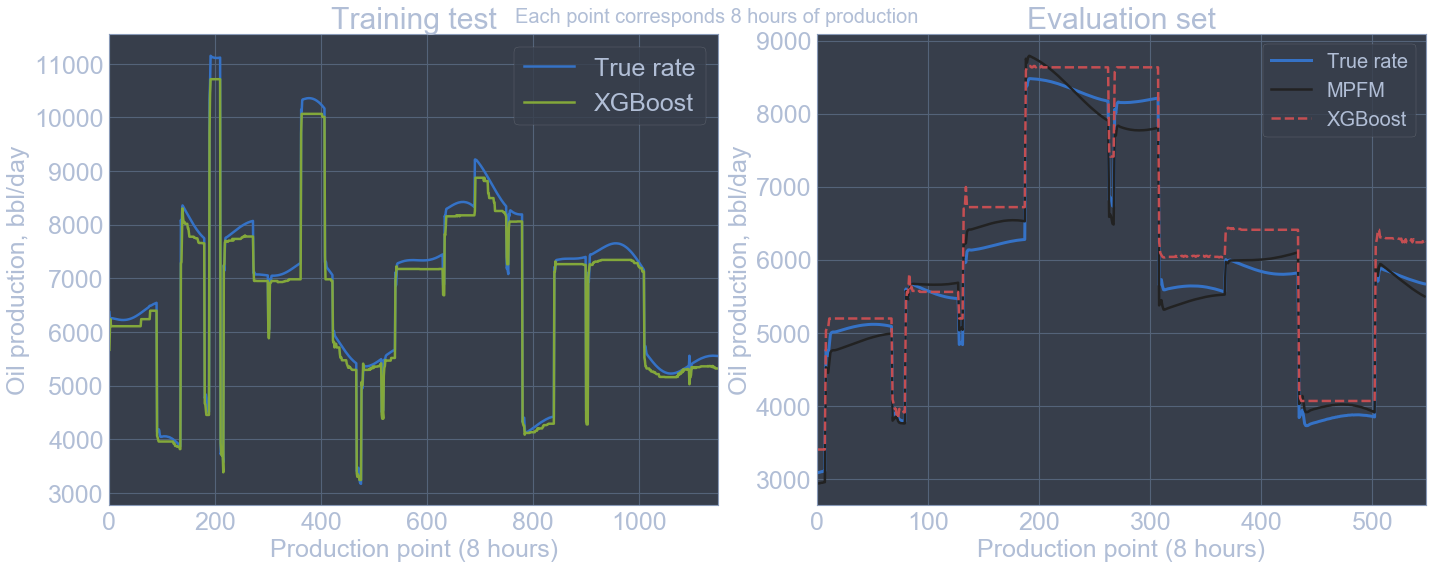

MAE XGBoost error in training is 167.30675838219398
MAPE XGBoost error in test set is 4.802137879974562
MAPE XGBoost error relative to truth in evaluation is 5.955415327921278


In [37]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, n_estimators =  int(final_score['n_estimators'][0]), 
                           gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), min_child_weight = final_score['min_child_weight'][0])
            
#clf.fit(np.array(X_1_train), np.array(y_1_train))
clf.fit(np.array(X_3_ES), np.array(y_3_ES))
predict_train = clf.predict(np.array(X_3_ES))
predict_test = clf.predict(np.array(X_3_test))
predict_eval = clf.predict(np.array(X_4))

#Plotting
plot_function(y_true_train=y_3_ES, y_pred_train=predict_train, y_true_test=y_4_true, y_MPFM_test=y_4, y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_3_ES, predict_train))
print ('MAPE XGBoost error in test set is', mean_absolute_percentage_error(y_3_test.values, predict_test.reshape(y_3_test.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', mean_absolute_percentage_error(y_4_true.values, predict_eval.reshape(y_4_true.shape[0], 1)))

# Case 2

### Case 2.1

In [38]:
#Parameters for case 1.1
STEP_NUM = 10
RATE = 0.1
FRACTION = 1
MAX_ESTIM = 40
MAX_DEPTH = 6

In [39]:
%%time
output_cv_1, output_stopping_1 = Random_search_selection(features_cv = X_1_CV_2, target_cv = y_1_CV_2, features_es = X_1_ES_2, 
                                                         target_es = y_1_ES_2, features_val = X_1_val, target_val = y_1_val, 
                                                         features_test = X_1_test, target_test = y_1_test, features_eval = X_2, 
                                                         target_eval = y_2,  early_stopping_check = 'Yes', error_type = 'mae', 
                                                         num_of_steps = STEP_NUM, cv_number = 5, learn_rate = RATE, 
                                                         fraction = FRACTION, max_estim_num = MAX_ESTIM, depth_limit = MAX_DEPTH)

[0]	validation_0-mae:6511.69
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:206.918
Stopping. Best iteration:
[78]	validation_0-mae:190.29

[0]	validation_0-mae:6511.01
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:203.184
Stopping. Best iteration:
[48]	validation_0-mae:201.551

[0]	validation_0-mae:6530.34
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:225.454
Stopping. Best iteration:
[50]	validation_0-mae:225.454

[0]	validation_0-mae:6499.38
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:161.243
Stopping. Best iteration:
[54]	validation_0-mae:160.341

[0]	validation_0-mae:6526.08
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:227.061
Stopping. Best iteration:
[68]	validation_0-mae:213.887

[0]	validation_0-mae:6511.35
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validatio

Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[27]	validation_0-mae:480.27

[0]	validation_0-mae:6552.57
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:183.362
Stopping. Best iteration:
[47]	validation_0-mae:176.101

[0]	validation_0-mae:6514.06
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:176.687
Stopping. Best iteration:
[48]	validation_0-mae:175.023

[0]	validation_0-mae:6511.35
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:255.625
Stopping. Best iteration:
[56]	validation_0-mae:246.656

[0]	validation_0-mae:6511.69
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:206.918
Stopping. Best iteration:
[78]	validation_0-mae:190.29

[0]	validation_0-mae:6515.4
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:212.708
Stopping. Best iteration:
[72]	validation_0-m

Stopping. Best iteration:
[46]	validation_0-mae:163.547

[0]	validation_0-mae:6512.93
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[44]	validation_0-mae:122.027

[0]	validation_0-mae:6633.39
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[26]	validation_0-mae:500.087

[0]	validation_0-mae:6507.09
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:133.79
Stopping. Best iteration:
[45]	validation_0-mae:122.824

[0]	validation_0-mae:6516.41
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:191.367
Stopping. Best iteration:
[57]	validation_0-mae:187.52

Wall time: 12.7 s


### Cross-validation

In [40]:
final_scores_random = np.array(output_cv_1).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mae_eval', 'mae_test', 'mae_train', 'n_estimators', 'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval,mae_test,mae_train,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,176.734570,126.945481,172.563898,39.0,3.0,6.934343,3.234222,3.0
1,158.824234,110.458255,174.440561,38.0,3.0,4.321212,17.141196,3.0
2,177.088998,146.484917,186.864740,37.0,7.0,1.105051,18.429742,2.0
3,141.443647,101.165627,190.686686,36.0,5.0,2.512121,17.435145,3.0
4,167.712118,155.457092,196.518843,39.0,4.0,7.738384,3.058412,2.0


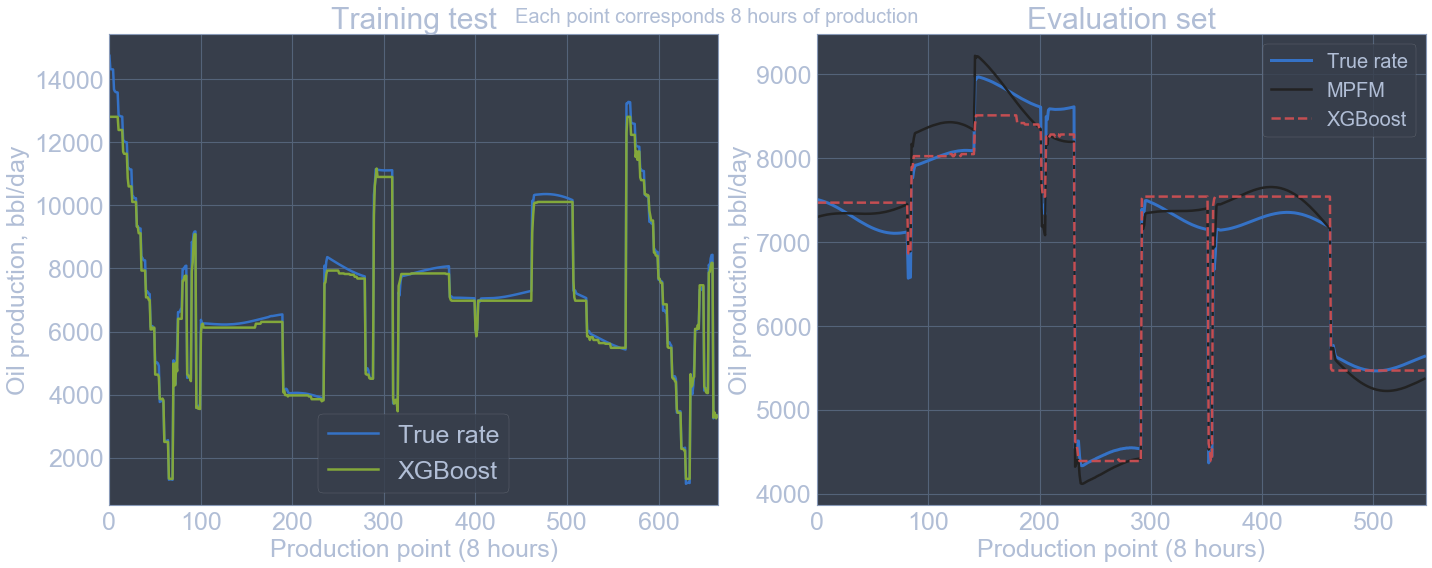

MAE XGBoost error in training is 172.56389784239525
MAPE XGBoost error relative to truth in training is 2.3177785080561253
MAPE XGBoost error relative to truth in evaluation is 2.7022772270480724


In [41]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, n_estimators =  int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), min_child_weight = final_score['min_child_weight'][0])

#Checking the obtained error       
clf.fit(np.array(X_1_CV_2), np.array(y_1_CV_2))
predict_train = clf.predict(np.array(X_1_CV_2))
predict_eval = clf.predict(np.array(X_2))

#Plotting
plot_function(y_true_train=y_1_CV_2, y_pred_train=predict_train, y_true_test=y_2_true, y_MPFM_test=y_2, y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_1_CV_2, predict_train))
print ('MAPE XGBoost error relative to truth in training is', mean_absolute_percentage_error(y_1_CV_2, predict_train.reshape(y_1_CV_2.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', mean_absolute_percentage_error(y_2_true.values, predict_eval.reshape(y_2_true.shape[0], 1)))

## Early stopping

In [42]:
final_scores_random = np.array(output_stopping_1).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mae_eval_stopping', 'mae_test_stopping', 'mae_train_stopping', 'n_estimators', \
                                      'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval_stopping,mae_test_stopping,mae_train_stopping,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,188.661221,240.007662,86.608616,31.0,5.0,3.919192,12.343404,5.0
1,188.661221,240.007662,86.608616,26.0,3.0,13.969697,7.601143,1.0
2,188.661221,240.007662,86.608616,37.0,3.0,0.502020,17.139710,3.0
3,188.661221,240.007662,86.608616,37.0,4.0,16.582828,3.132639,3.0
4,188.661221,240.007662,86.608616,25.0,7.0,18.391919,4.021846,3.0


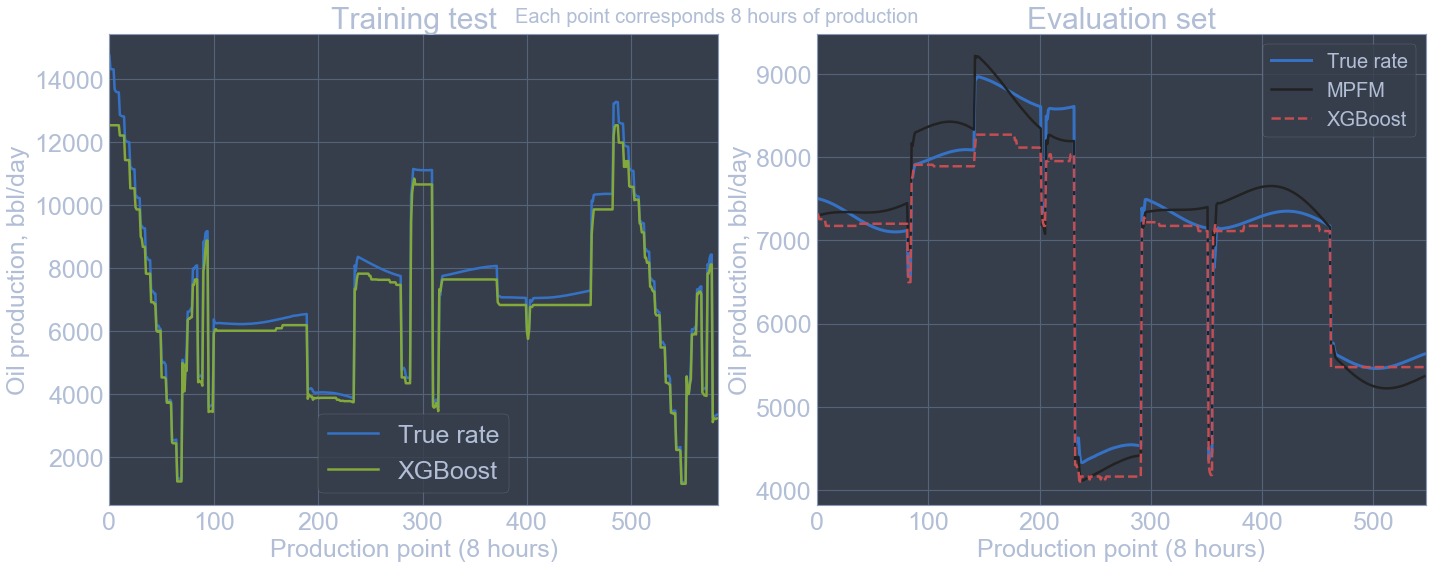

MAE XGBoost error in training is 316.0655872066225
MAPE XGBoost error in test set is 2.711072728129583
MAPE XGBoost error relative to truth in evaluation is 2.999489766422831


In [43]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, n_estimators =  int(final_score['n_estimators'][0]), 
                           gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), min_child_weight = final_score['min_child_weight'][0])
            
#clf.fit(np.array(X_1_train), np.array(y_1_train))
clf.fit(np.array(X_1_ES_2), np.array(y_1_ES_2))
predict_train = clf.predict(np.array(X_1_ES_2))
predict_test = clf.predict(np.array(X_1_test))
predict_eval = clf.predict(np.array(X_2))

#Plotting
plot_function(y_true_train=y_1_ES_2, y_pred_train=predict_train, y_true_test=y_2_true, y_MPFM_test=y_2, y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_1_ES_2, predict_train))
print ('MAPE XGBoost error in test set is', mean_absolute_percentage_error(y_1_test.values, predict_test.reshape(y_1_test.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', mean_absolute_percentage_error(y_2_true.values, predict_eval.reshape(y_2_true.shape[0], 1)))

### Case 2.2

In [44]:
#Parameters for case 2.2
STEP_NUM = 10
RATE = 0.1
FRACTION = 1
MAX_ESTIM = 40
MAX_DEPTH = 6

In [45]:
%%time
output_cv_2, output_stopping_2 = Random_search_selection(features_cv = X_2_CV, target_cv = y_2_CV, features_es = X_2_ES, 
                                                         target_es = y_2_ES, features_val = X_2_val, target_val = y_2_val, 
                                                         features_test = X_2_test, target_test = y_2_test, features_eval = X_3, 
                                                         target_eval = y_3,  early_stopping_check = 'Yes', error_type = 'mae', 
                                                         num_of_steps = STEP_NUM, cv_number = 5, learn_rate = RATE, 
                                                         fraction = FRACTION, max_estim_num = MAX_ESTIM, depth_limit = MAX_DEPTH)

[0]	validation_0-mae:5577.98
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[30]	validation_0-mae:104.784

[0]	validation_0-mae:5577.33
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[38]	validation_0-mae:91.1804

[0]	validation_0-mae:5572.24
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:100.808
Stopping. Best iteration:
[62]	validation_0-mae:95.2142

[0]	validation_0-mae:5625.3
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[32]	validation_0-mae:76.6575

[0]	validation_0-mae:5565.51
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	validation_0-mae:102.714

[0]	validation_0-mae:5577.66
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	validation_0-mae:104.482

[0]	validation_0-mae:5577.98
Will train until validation_0-mae hasn't improve

[0]	validation_0-mae:5608.04
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[29]	validation_0-mae:112.025

[0]	validation_0-mae:5639.02
Will train until validation_0-mae hasn't improved in 5 rounds.
[50]	validation_0-mae:114.38
Stopping. Best iteration:
[55]	validation_0-mae:111.863

[0]	validation_0-mae:5571.91
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[27]	validation_0-mae:135.575

[0]	validation_0-mae:5646.43
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[40]	validation_0-mae:144.227

[0]	validation_0-mae:5608.71
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[39]	validation_0-mae:93.3179

[0]	validation_0-mae:5611.72
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[33]	validation_0-mae:96.7096

[0]	validation_0-mae:5577.98
Will train until validation_0-mae hasn't improve

### Cross-validation

In [46]:
final_scores_random = np.array(output_cv_2).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mape_eval', 'mape_test', 'mape_train', 'n_estimators', 'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mape_eval,mape_test,mape_train,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,360.922484,227.935144,151.013971,38.0,3.0,4.321212,17.141196,3.0
1,377.201353,187.276153,152.193677,38.0,2.0,2.914141,18.900596,2.0
2,369.927898,183.747733,153.658837,39.0,4.0,7.738384,3.058412,2.0
3,308.586499,223.346646,171.665660,37.0,6.0,5.929293,5.077554,5.0
4,321.395009,213.936034,173.469267,36.0,7.0,1.909091,12.967298,5.0


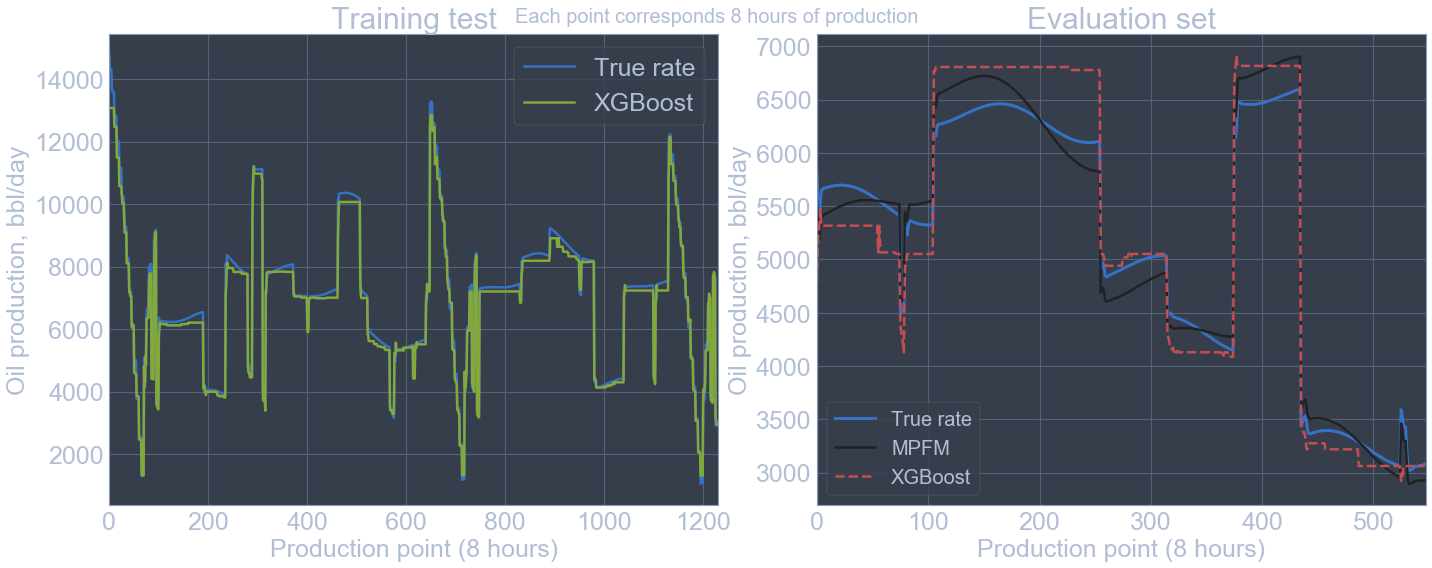

MAE error in training is 168.85346447168433
MAPE error in training is 2.4624358135218336
MAPE error with truth is 5.281221336173432


In [47]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, n_estimators =  int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), min_child_weight = final_score['min_child_weight'][0])

#Checking the obtained error       
clf.fit(np.array(X_2_CV_2), np.array(y_2_CV_2))
predict_train = clf.predict(np.array(X_2_CV_2))
predict_eval = clf.predict(np.array(X_3))

#Plotting
plot_function(y_true_train=y_2_CV_2, y_pred_train=predict_train, y_true_test=y_3_true, y_MPFM_test=y_3, y_pred_test=predict_eval)

print ('MAE error in training is', mean_absolute_error(y_2_CV_2, predict_train))
print ('MAPE error in training is', mean_absolute_percentage_error(y_2_CV_2, predict_train.reshape(y_2_CV_2.shape[0], 1)))
print ('MAPE error with truth is', mean_absolute_percentage_error(y_3_true.values, predict_eval.reshape(y_3_true.shape[0], 1)))

### Early stopping

In [48]:
final_scores_random = np.array(output_stopping_2).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mae_eval_stopping', 'mae_test_stopping', 'mae_train_stopping', 'n_estimators', \
                                      'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval_stopping,mae_test_stopping,mae_train_stopping,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,340.744435,133.792422,102.387277,36.0,6.0,1.909091,18.953031,4.0
1,340.744435,133.792422,102.387277,31.0,3.0,17.989899,17.056875,3.0
2,331.377392,140.691980,350.294998,25.0,1.0,16.180808,2.421177,2.0
3,331.377392,140.691980,350.294998,31.0,5.0,3.919192,12.343404,5.0
4,331.377392,140.691980,350.294998,26.0,3.0,13.969697,7.601143,1.0


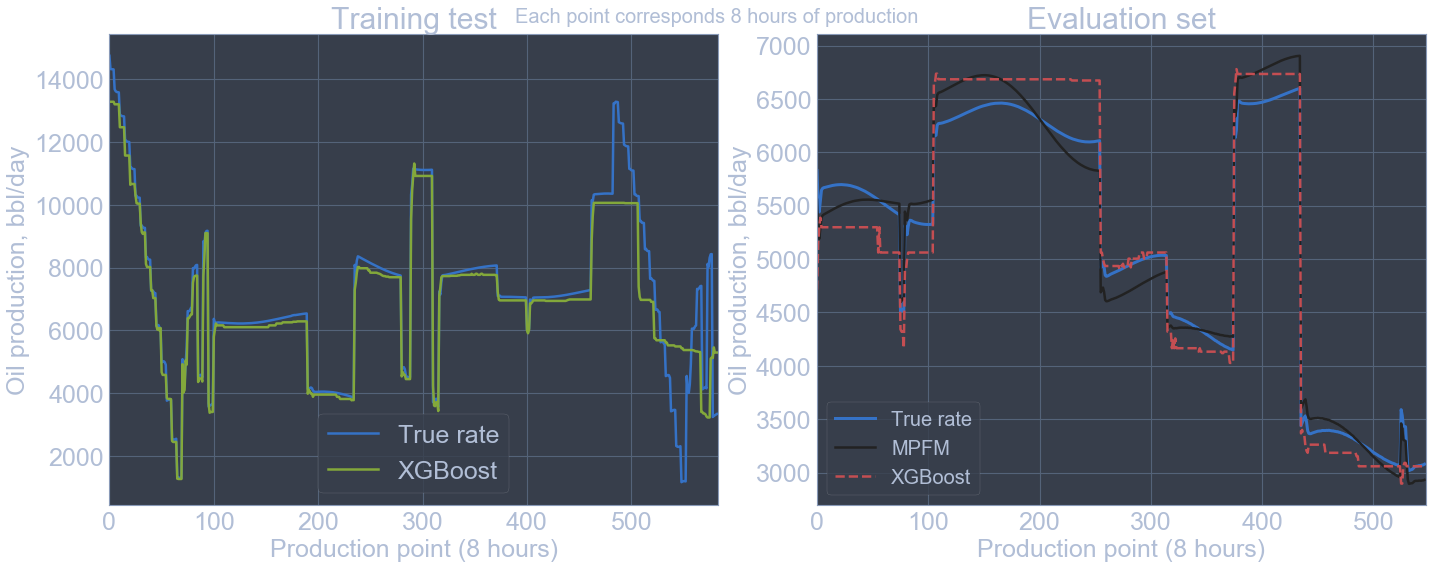

MAE XGBoost error in training is 183.95544957651032
MAPE XGBoost error in test set is 3.5997695460857257
MAPE XGBoost error relative to truth in evaluation is 4.652014524700888


In [49]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, n_estimators =  int(final_score['n_estimators'][0]), 
                           gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), min_child_weight = final_score['min_child_weight'][0])
            
#clf.fit(np.array(X_1_train), np.array(y_1_train))
clf.fit(np.array(X_2_ES_2), np.array(y_2_ES_2))
predict_train = clf.predict(np.array(X_2_ES_2))
predict_test = clf.predict(np.array(X_2_test))
predict_eval = clf.predict(np.array(X_3))

#Plotting
plot_function(y_true_train=y_1_ES_2, y_pred_train=predict_train, y_true_test=y_3_true, y_MPFM_test=y_3, y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_2_ES_2, predict_train))
print ('MAPE XGBoost error in test set is', mean_absolute_percentage_error(y_2_test.values, predict_test.reshape(y_2_test.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', mean_absolute_percentage_error(y_3_true.values, predict_eval.reshape(y_3_true.shape[0], 1)))

### Case 2.3

In [50]:
STEP_NUM = 10
RATE = 0.1
FRACTION = 1
MAX_ESTIM = 40
MAX_DEPTH = 6

In [51]:
%%time
output_cv_3, output_stopping_3 = Random_search_selection(features_cv = X_3_CV, target_cv = y_3_CV, features_es = X_3_ES, 
                                                         target_es = y_3_ES, features_val = X_3_val, target_val = y_3_val, 
                                                         features_test = X_3_test, target_test = y_3_test, features_eval = X_4, 
                                                         target_eval = y_4,  early_stopping_check = 'Yes', error_type = 'mae', 
                                                         num_of_steps = STEP_NUM, cv_number = 5, learn_rate = RATE, 
                                                         fraction = FRACTION, max_estim_num = MAX_ESTIM, depth_limit = MAX_DEPTH)

[0]	validation_0-mae:5215.68
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[23]	validation_0-mae:330.553

[0]	validation_0-mae:5213.38
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[23]	validation_0-mae:324.805

[0]	validation_0-mae:5212.73
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[23]	validation_0-mae:329.703

[0]	validation_0-mae:5189.93
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:324.711

[0]	validation_0-mae:5211.41
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[23]	validation_0-mae:326.002

[0]	validation_0-mae:5213.6
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:330.838

[0]	validation_0-mae:5215.68
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best 

Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:325.167

[0]	validation_0-mae:5212.51
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:323.183

[0]	validation_0-mae:5226.9
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[24]	validation_0-mae:325.449

[0]	validation_0-mae:5217.2
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:324.674

[0]	validation_0-mae:5219.14
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-mae:327.221

[0]	validation_0-mae:5215.68
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[23]	validation_0-mae:330.553

[0]	validation_0-mae:5218.06
Will train until validation_0-mae hasn't improved in 5 rounds.
Stopping. Best iteration:
[22]	validation_0-m

In [52]:
final_scores_random = np.array(output_cv_3).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mape_eval', 'mape_test', 'mape_train', 'n_estimators', 'min_child_weight', 
                                      'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mape_eval,mape_test,mape_train,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,231.618576,164.770271,136.429462,39.0,3.0,6.934343,3.234222,3.0
1,211.229805,180.933712,138.257369,38.0,3.0,3.517172,1.211411,5.0
2,228.718796,179.829534,158.966990,37.0,6.0,5.929293,5.077554,5.0
3,344.503136,202.534003,163.118935,36.0,7.0,1.909091,12.967298,5.0
4,208.434312,205.858720,183.906778,36.0,4.0,11.155556,16.652645,5.0


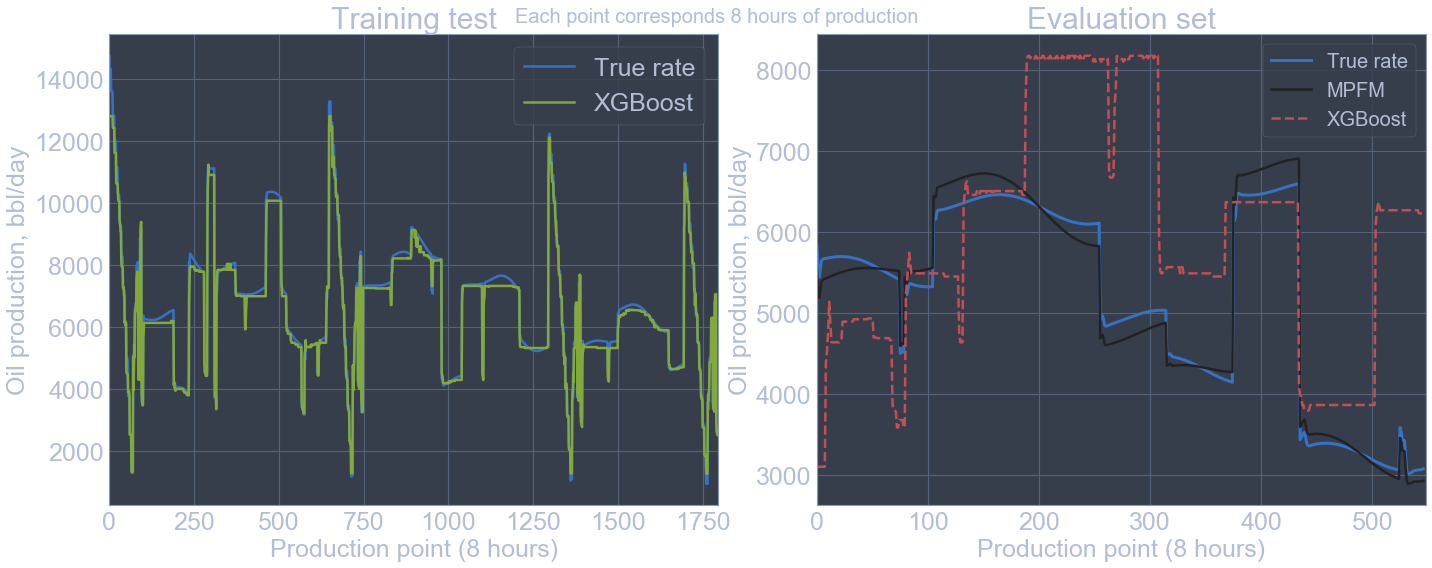

MAE XGBoost error in training is 157.3718317252123
MAPE XGBoost error relative to truth in training is 2.4421524070945364
MAPE XGBoost error relative to truth in evaluation is 3.823108570261703


In [53]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, n_estimators =  int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), min_child_weight = final_score['min_child_weight'][0])

#Checking the obtained error       
clf.fit(np.array(X_3_CV_2), np.array(y_3_CV_2))
predict_train = clf.predict(np.array(X_3_CV_2))
predict_eval = clf.predict(np.array(X_4))

#Plotting
plot_function(y_true_train=y_3_CV_2, y_pred_train=predict_train, y_true_test=y_3_true, y_MPFM_test=y_3, y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_3_CV_2, predict_train))
print ('MAPE XGBoost error relative to truth in training is', mean_absolute_percentage_error(y_3_CV_2, predict_train.reshape(y_3_CV_2.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', mean_absolute_percentage_error(y_4_true.values, predict_eval.reshape(y_4_true.shape[0], 1)))

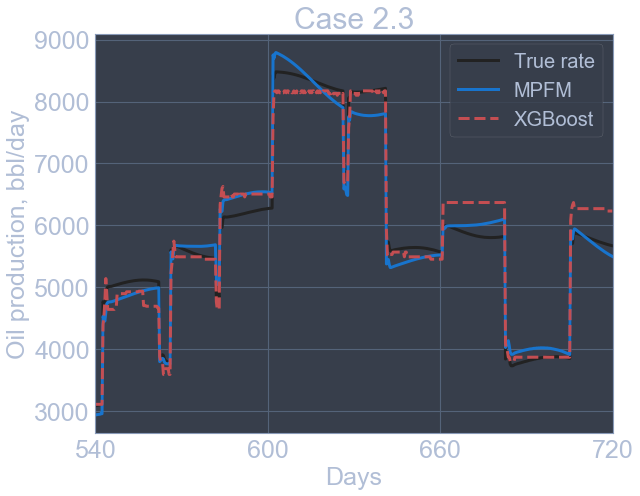

In [54]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, n_estimators =  int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), min_child_weight = final_score['min_child_weight'][0])

#Checking the obtained error       
clf.fit(np.array(X_3_CV_2), np.array(y_3_CV_2))
predict_train = clf.predict(np.array(X_3_CV_2))
predict_eval = clf.predict(np.array(X_4))
#Plotting
plt.figure(figsize = (9, 7))

ax2 = plt.subplot(1, 1, 1)
ax2.plot(np.array(y_4_true), label = 'True rate', linewidth = 3, color = 'k')
ax2.plot(np.array(y_4), label = 'MPFM', linewidth = 3, color = '#1874CD')
ax2.plot(predict_eval, label = 'XGBoost', linewidth = 3, linestyle = '--', color = 'r')
ax2.legend(fontsize = 20)
ax2.set_title('Case 2.3', size = 30)

#x-axis
ax2.set_xlabel('Days', size = 25)
ax2.set_xlim(0, 547.5)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(182.5))
x_values = [0, 540, 600, 660, 720]
plt.gca().xaxis.set_ticklabels(x_values, size = 25)

#y-axis
ax2.set_ylabel('Oil production, bbl/day', size = 25)
ax2.yaxis.set_tick_params(labelsize = 25)
plt.tight_layout()

#plt.savefig('Case_2.3.eps', dpi=1200, format = 'eps')

### Early stopping

In [55]:
final_scores_random = np.array(output_stopping_3).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[2]), 
                           columns = ['mae_eval_stopping', 'mae_test_stopping', 'mae_train_stopping', 'n_estimators', \
                                      'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval_stopping,mae_test_stopping,mae_train_stopping,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,235.257573,248.481103,457.817761,36.0,6.0,1.909091,18.953031,4.0
1,235.257573,248.481103,457.817761,31.0,3.0,17.989899,17.056875,3.0
2,281.979945,253.318140,497.165406,37.0,3.0,0.502020,17.139710,3.0
3,281.979945,253.318140,497.165406,37.0,4.0,16.582828,3.132639,3.0
4,281.979945,253.318140,497.165406,25.0,7.0,18.391919,4.021846,3.0


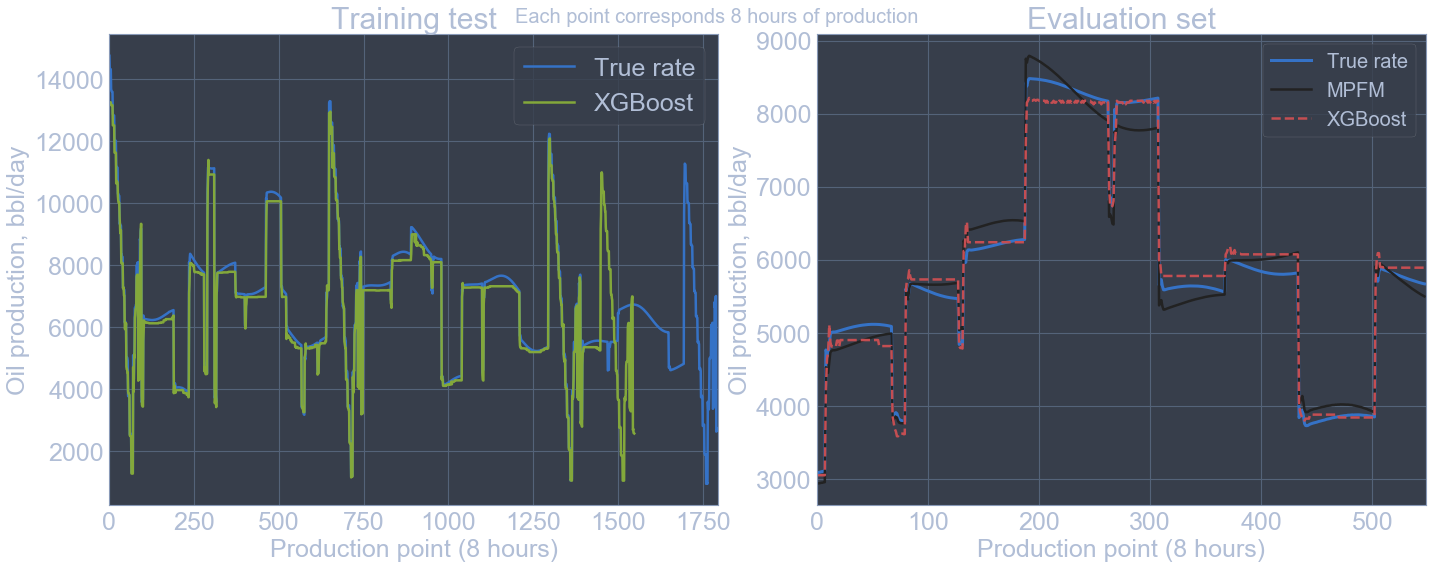

MAE XGBoost error in training is 173.74656804091333
MAPE XGBoost error in test set is 4.840186737117954
MAPE XGBoost error relative to truth in evaluation is 2.4687939188740557


In [56]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, n_estimators =  int(final_score['n_estimators'][0]), 
                           gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), min_child_weight = final_score['min_child_weight'][0])
            
#clf.fit(np.array(X_1_train), np.array(y_1_train))
clf.fit(np.array(X_3_ES_2), np.array(y_3_ES_2))
predict_train = clf.predict(np.array(X_3_ES_2))
predict_test = clf.predict(np.array(X_3_test))
predict_eval = clf.predict(np.array(X_4))

#Plotting
plot_function(y_true_train=y_3_CV_2, y_pred_train=predict_train, y_true_test=y_4_true, y_MPFM_test=y_4, y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_3_ES_2, predict_train))
print ('MAPE XGBoost error in test set is', mean_absolute_percentage_error(y_3_test.values, predict_test.reshape(y_3_test.shape[0], 1)))
print ('MAPE XGBoost error relative to truth in evaluation is', mean_absolute_percentage_error(y_4_true.values, predict_eval.reshape(y_4_true.shape[0], 1)))

## Case 3

### Case 3.1

In [57]:
#Parameters for case 3.1
STEP_NUM = 10
RATE = 0.1
FRACTION = 1
MAX_ESTIM = 80
MAX_DEPTH = 6

In [58]:
%%time
output_1 = Random_search_selection(features_cv = X_1_train, target_cv = y_1_train, features_es = [], 
                                                         target_es = [], features_val = [], target_val = [], 
                                                         features_test = X_1_train, target_test = y_1_train, features_eval = X_1, 
                                                         target_eval = y_1,  early_stopping_check = None, error_type = 'mae', 
                                                         num_of_steps = STEP_NUM, cv_number = None, learn_rate = RATE, 
                                                         fraction = FRACTION, max_estim_num = MAX_ESTIM, depth_limit = MAX_DEPTH)

Wall time: 705 ms


In [59]:
final_scores_random = np.array(output_1).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[1]), 
                           columns = ['mae_eval', 'mae_test', 'mae_train', 'n_estimators', 'min_child_weight', \
                                      'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval,mae_test,mae_train,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,439.942381,19.654506,19.654506,78.0,2.0,1.306061,2.682286,3.0
1,405.633077,28.462077,28.462077,56.0,5.0,0.301010,6.248464,5.0
2,444.123288,36.155515,36.155515,78.0,6.0,3.316162,8.537982,5.0
3,523.129587,39.990353,39.990353,78.0,7.0,0.502020,19.074765,3.0
4,458.739911,40.782892,40.782892,76.0,1.0,5.929293,0.609938,3.0


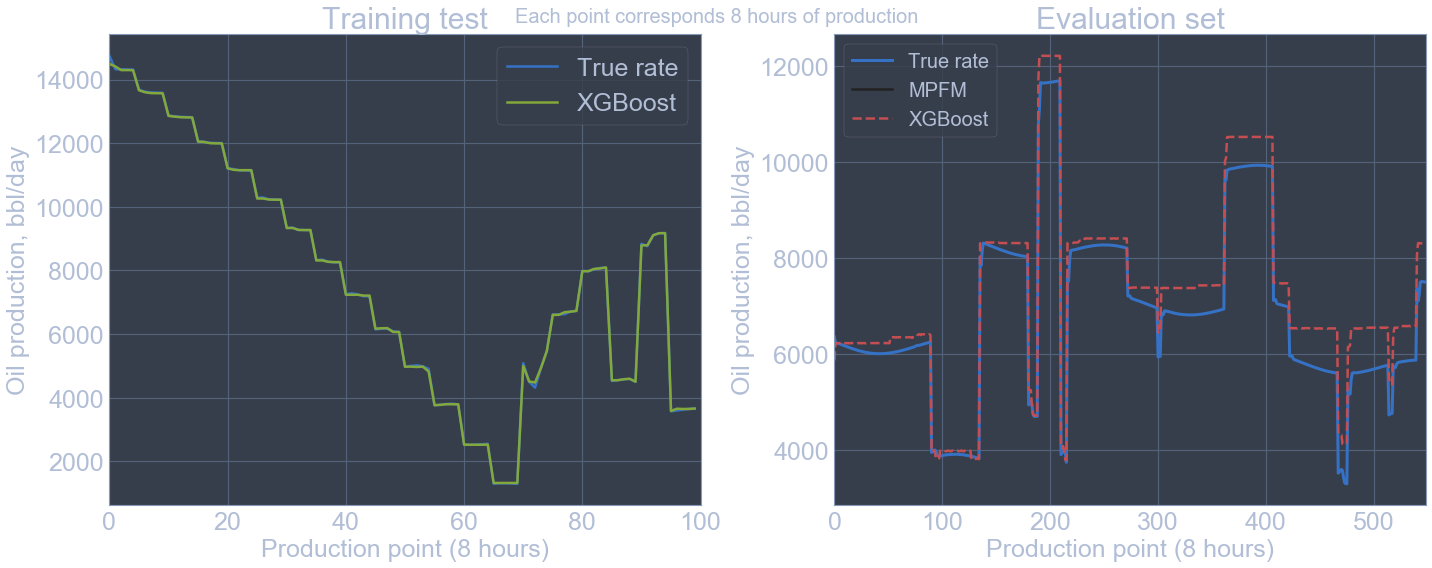

MAE XGBoost error in training is 19.654505674832563
MAPE XGBoost error relative to truth in evaluation is 7.009908312935536


In [60]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, n_estimators =  int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), min_child_weight = final_score['min_child_weight'][0])
            
clf.fit(np.array(X_1_train), np.array(y_1_train))
predict_train = clf.predict(np.array(X_1_train))
predict_eval = clf.predict(np.array(X_1))

#Plotting
plot_function(y_true_train=y_1_train, y_pred_train=predict_train, y_true_test=y_1_true, y_MPFM_test=[], y_pred_test=predict_eval)
#plt.savefig('Case_3_OF.jpg', dpi=1200, format='jpg')

print ('MAE XGBoost error in training is', mean_absolute_error(y_1_train, predict_train))
print ('MAPE XGBoost error relative to truth in evaluation is', mean_absolute_percentage_error(y_1.values, predict_eval.reshape(y_1.shape[0], 1)))

### Case 3.2

In [61]:
#Parameters for case 3.2
STEP_NUM = 10
RATE = 0.1
FRACTION = 1
MAX_ESTIM = 80 #AF -40, OF- 60
MAX_DEPTH = 6

In [62]:
%%time
output_2 = Random_search_selection(features_cv = X_2_train, target_cv = y_2_train, features_es = [], 
                                                         target_es = [], features_val = [], target_val = [], 
                                                         features_test = X_2_train, target_test = y_2_train, features_eval = X_2, 
                                                         target_eval = y_2,  early_stopping_check = None, error_type = 'mae', 
                                                         num_of_steps = STEP_NUM, cv_number = None, learn_rate = RATE, 
                                                         fraction = FRACTION, max_estim_num = MAX_ESTIM, depth_limit = MAX_DEPTH)

Wall time: 1.11 s


In [63]:
final_scores_random = np.array(output_2).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[1]), 
                           columns = ['mae_eval', 'mae_test', 'mae_train', 'n_estimators', 'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval,mae_test,mae_train,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,188.235525,30.768694,30.768694,56.0,5.0,0.301010,6.248464,5.0
1,198.206491,33.468203,33.468203,63.0,3.0,0.703030,10.926656,4.0
2,209.544641,48.194407,48.194407,78.0,7.0,0.502020,19.074765,3.0
3,249.987453,50.172410,50.172410,78.0,6.0,3.316162,8.537982,5.0
4,188.579590,51.718954,51.718954,48.0,4.0,0.100000,5.624777,5.0


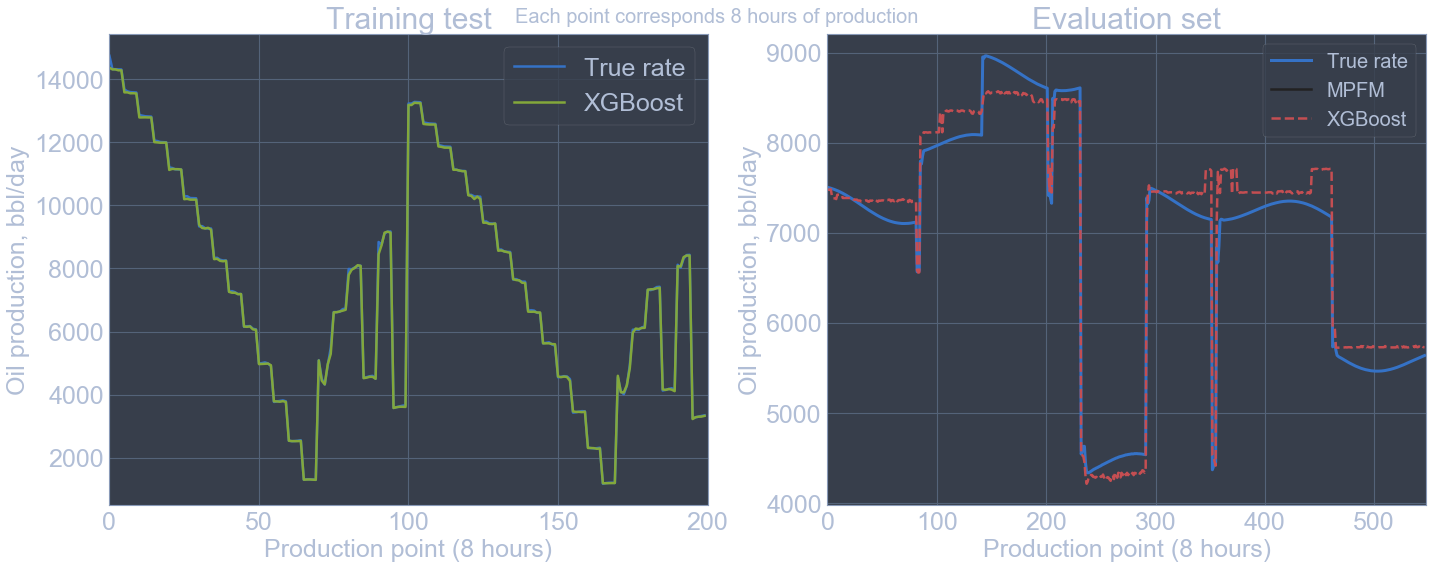

MAE XGBoost error in training is 30.768694179630394
MAPE XGBoost error relative to truth in evaluation is 2.8538613692369617


In [64]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, n_estimators =  int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), min_child_weight = final_score['min_child_weight'][0])
            
clf.fit(np.array(X_2_train), np.array(y_2_train))
predict_train = clf.predict(np.array(X_2_train))
predict_eval = clf.predict(np.array(X_2))

#Plotting
plot_function(y_true_train=y_2_train, y_pred_train=predict_train, y_true_test=y_2_true, y_MPFM_test=[], y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_2_train, predict_train))
print ('MAPE XGBoost error relative to truth in evaluation is', mean_absolute_percentage_error(y_2.values, predict_eval.reshape(y_2.shape[0], 1)))

### Case 3.3

In [65]:
#Parameters for case 3.3
STEP_NUM = 10
RATE = 0.1
FRACTION = 1
MAX_ESTIM = 95
MAX_DEPTH = 6

In [66]:
%%time
output_3 = Random_search_selection(features_cv = X_3_train, target_cv = y_3_train, features_es = [], 
                                                         target_es = [], features_val = [], target_val = [], 
                                                         features_test = X_3_train, target_test = y_3_train, features_eval = X_3, 
                                                         target_eval = y_3,  early_stopping_check = None, error_type = 'mae', 
                                                         num_of_steps = STEP_NUM, cv_number = None, learn_rate = RATE, 
                                                         fraction = FRACTION, max_estim_num = MAX_ESTIM, depth_limit = MAX_DEPTH)

Wall time: 1.71 s


In [67]:
final_scores_random = np.array(output_3).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[1]), 
                           columns = ['mae_eval', 'mae_test', 'mae_train', 'n_estimators', 'min_child_weight', 'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval,mae_test,mae_train,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,188.316334,35.293787,35.293787,89.0,5.0,1.105051,11.643134,5.0
1,179.523005,45.014660,45.014660,70.0,4.0,0.703030,15.397973,4.0
2,182.436362,46.566952,46.566952,80.0,4.0,2.512121,16.652645,5.0
3,214.322419,50.402821,50.402821,79.0,3.0,1.909091,14.498979,4.0
4,174.136736,60.163480,60.163480,64.0,6.0,1.507071,11.133147,4.0


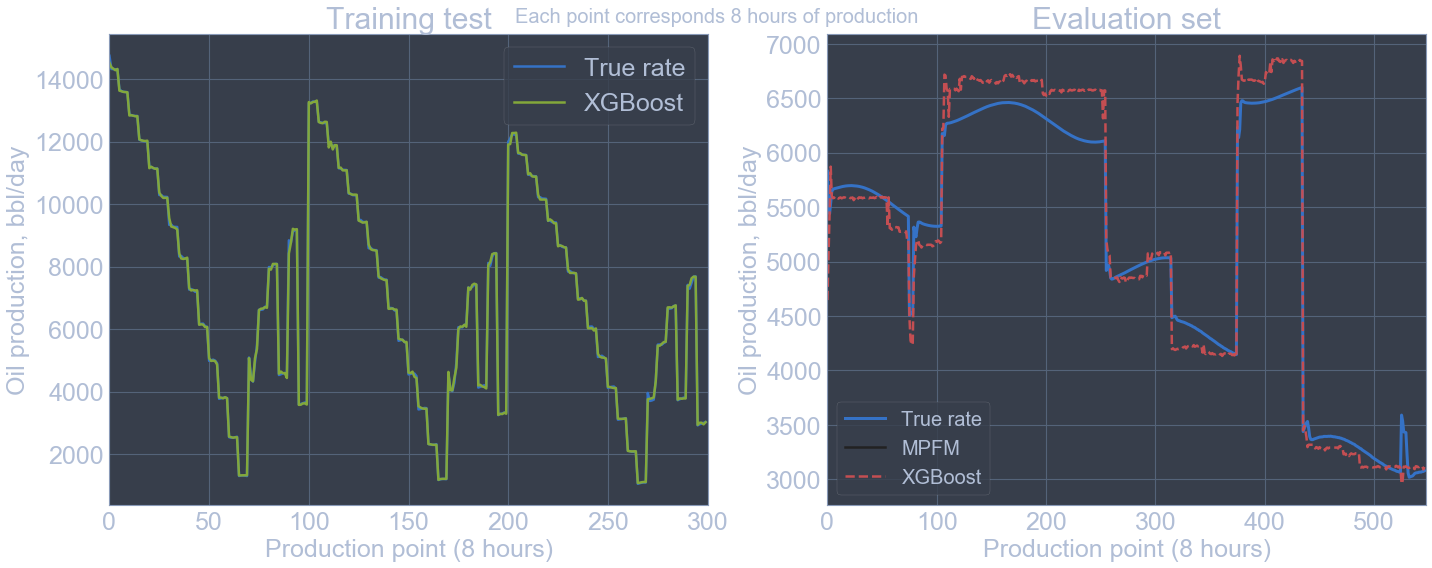

MAE XGBoost error in training is 35.293787042302306
MAPE XGBoost error relative to truth in evaluation is 3.8283869268016746


In [68]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, n_estimators =  int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), min_child_weight = final_score['min_child_weight'][0])
            
clf.fit(np.array(X_3_train), np.array(y_3_train))
predict_train = clf.predict(np.array(X_3_train))
predict_eval = clf.predict(np.array(X_3))

#Plotting
plot_function(y_true_train=y_3_train, y_pred_train=predict_train, y_true_test=y_3_true, y_MPFM_test=[], y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_3_train, predict_train))
print ('MAPE XGBoost error relative to truth in evaluation is', mean_absolute_percentage_error(y_3.values, predict_eval.reshape(y_3.shape[0], 1)))

### Case 3.4

In [69]:
#Parameters for case 3.4
STEP_NUM = 10
RATE = 0.1
FRACTION = 1
MAX_ESTIM = 80
MAX_DEPTH = 6

In [70]:
%%time
output_4 = Random_search_selection(features_cv = X_4_train, target_cv = y_4_train, features_es = [], 
                                                         target_es = [], features_val = [], target_val = [], 
                                                         features_test = X_4_train, target_test = y_4_train, features_eval = X_4, 
                                                         target_eval = y_4,  early_stopping_check = None, error_type = 'mae', 
                                                         num_of_steps = STEP_NUM, cv_number = None, learn_rate = RATE, 
                                                         fraction = FRACTION, max_estim_num = MAX_ESTIM, depth_limit = MAX_DEPTH)

Wall time: 1.97 s


In [71]:
final_scores_random = np.array(output_4).reshape((8, STEP_NUM)).T
final_score = pd.DataFrame(sorted(final_scores_random, key=lambda column: column[1]), 
                           columns = ['mae_eval','mae_test', 'mae_train', 'n_estimators', 'min_child_weight', \
                                      'reg_lambda', 'gamma', 'max_depth'])
final_score.head()

,mae_eval,mae_test,mae_train,n_estimators,min_child_weight,reg_lambda,gamma,max_depth
0,181.822775,44.160686,44.160686,56.0,5.0,0.301010,6.248464,5.0
1,191.387764,54.749012,54.749012,63.0,3.0,0.703030,10.926656,4.0
2,199.426539,56.868170,56.868170,48.0,4.0,0.100000,5.624777,5.0
3,206.580722,58.859816,58.859816,78.0,6.0,3.316162,8.537982,5.0
4,188.297843,72.282638,72.282638,78.0,7.0,0.502020,19.074765,3.0


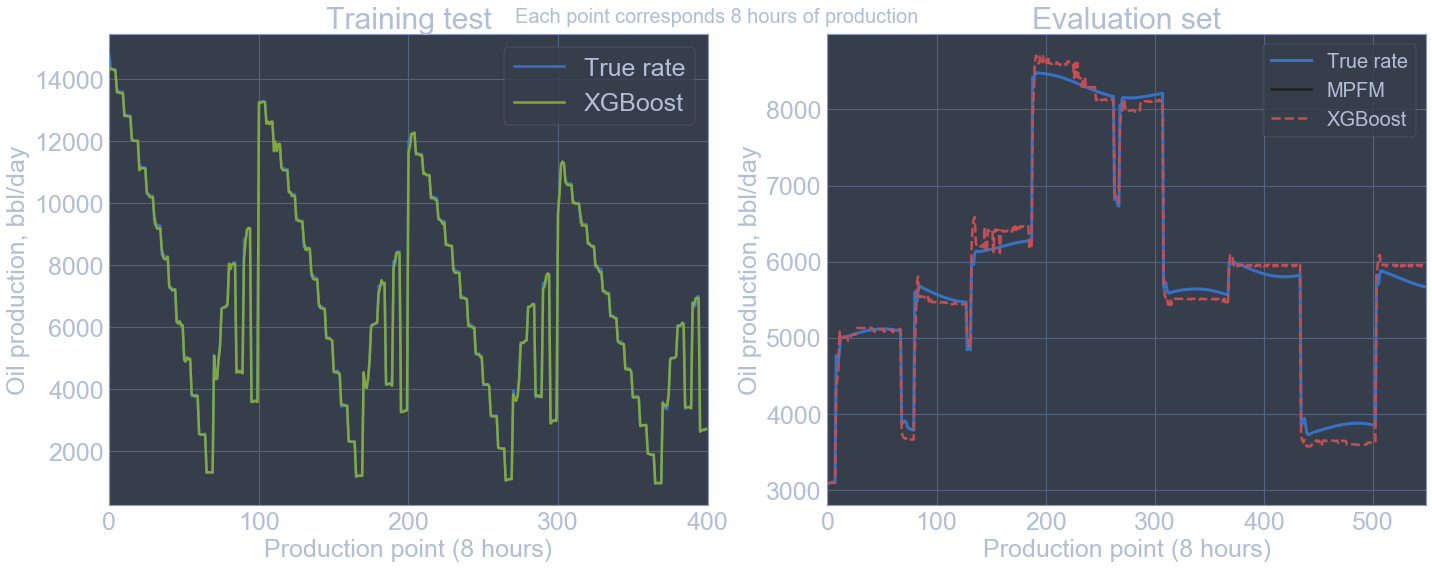

MAE XGBoost error in training is 44.16068598340598
MAPE XGBoost error relative to truth in evaluation is 3.4499987169684982


In [72]:
clf = xgb.XGBRegressor(learning_rate =  RATE, subsample = FRACTION, n_estimators =  int(final_score['n_estimators'][0]), 
                       gamma = final_score['gamma'][0], reg_lambda = final_score['reg_lambda'][0], 
                       max_depth = int(final_score['max_depth'][0]), min_child_weight = final_score['min_child_weight'][0])
            
clf.fit(np.array(X_4_train), np.array(y_4_train))
predict_train = clf.predict(np.array(X_4_train))
predict_eval = clf.predict(np.array(X_4))

#Plotting
plot_function(y_true_train=y_4_train, y_pred_train=predict_train, y_true_test=y_4_true, y_MPFM_test=[], y_pred_test=predict_eval)

print ('MAE XGBoost error in training is', mean_absolute_error(y_4_train, predict_train))
print ('MAPE XGBoost error relative to truth in evaluation is', mean_absolute_percentage_error(y_4.values, predict_eval.reshape(y_4.shape[0], 1)))